In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [40]:
from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_history, plot_distributions, plot_samples
import matplotlib.pyplot as plt
import torch
from TargetDistributions.MoG import MoG
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
torch.set_default_dtype(torch.float64)

def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples(*args, **kwargs)
    plt.show()

# Specifiy target distribution and key param

## MoG

tensor(47.9914)


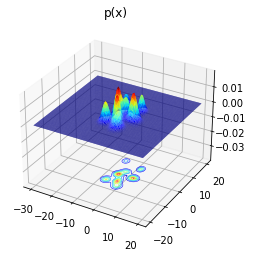

In [5]:
torch.manual_seed(2)
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=1, loc_scaling=5)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
if dim == 2:
    fig = plot_distribution(target, bounds=[[-30, 20], [-20, 20]])

# Setup AIS training

In [6]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=5.0, flow_type="RealNVP", n_flow_steps=10)
tester = AIS_trainer(target, learnt_sampler, loss_type="kl", n_distributions=20, n_steps_transition_operator=3,
                    step_size=1.0)

## Visualisation before training
Let's look at the effective sample size before training of vanilla IS vs annealed IS

In [7]:
n_samples_expectation = int(1e5)
n_samples=int(1e4)

In [8]:
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
with torch.no_grad():
    expectation_vanilla, info_dict_vanilla = \
    vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation_vanilla}")
print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
      var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

true expectation is 47.991433012778494, estimated expectation is 48.43030258521752
ESS is 0.32835271579261954,       var is 2.0455259495146142e-10


true expectation is 47.991433012778494, estimated expectation is 48.52313020646275
ESS is 0.5388227866655135, var is 8.559063138490273e-11


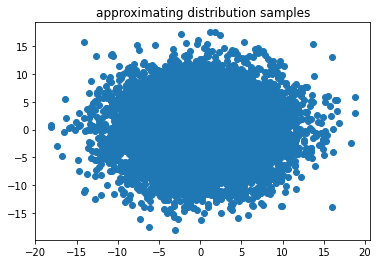

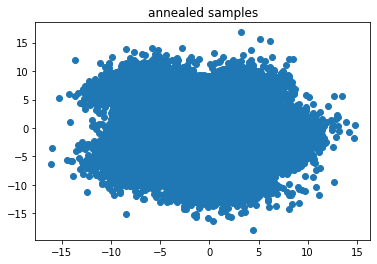

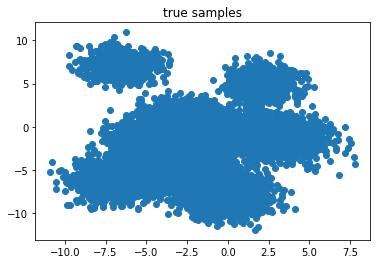

In [9]:
with torch.no_grad():
    expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(
    f"ESS is {info_dict['effective_sample_size'] / n_samples_expectation}, "
    f"var is {torch.var(info_dict['normalised_sampling_weights'])}")

plt.figure()
learnt_dist_samples = learnt_sampler.sample((n_samples,)).cpu().detach()
plt.scatter(learnt_dist_samples[:, 0], learnt_dist_samples[:, 1])
plt.title("approximating distribution samples")
plt.show()
plt.figure()
plt.scatter(info_dict["samples"][:, 0].cpu(), info_dict["samples"][:, 1].cpu())
plt.title("annealed samples")
plt.show()
plt.figure()
true_samples = target.sample((n_samples,)).cpu().detach()
plt.scatter(true_samples[:, 0], true_samples[:, 1])
plt.title("true samples")
plt.show()

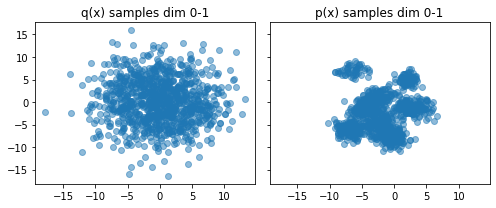

In [10]:
plot_samples(tester)

## Now let's train

loss: 0.8582645983796954, mean log p_x -5.863425979459226:   0%|                                                                                               | 0/100 [00:01<?, ?it/s]

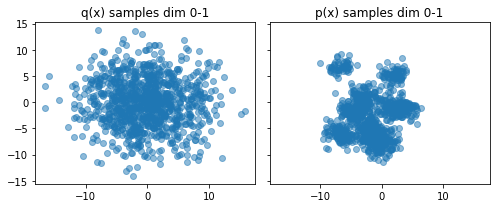

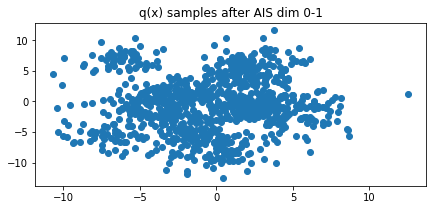

loss: 0.32647604064153113, mean log p_x -5.452701953503238:  10%|████████▌                                                                            | 10/100 [00:16<02:18,  1.54s/it]

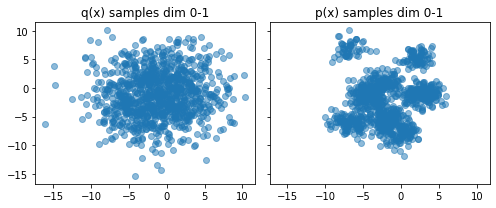

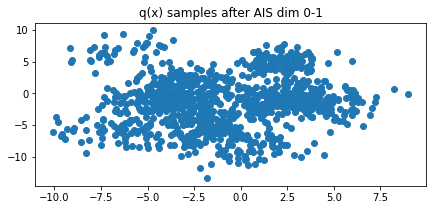

loss: 0.21489224527606154, mean log p_x -5.274284966915219:  20%|█████████████████                                                                    | 20/100 [00:31<01:49,  1.37s/it]

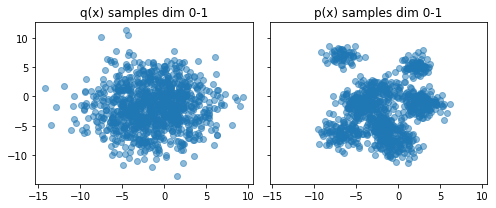

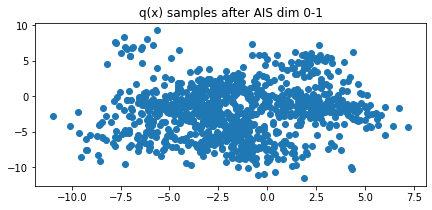

loss: 0.17940701789961164, mean log p_x -5.222818565077306:  30%|█████████████████████████▌                                                           | 30/100 [00:46<01:42,  1.46s/it]

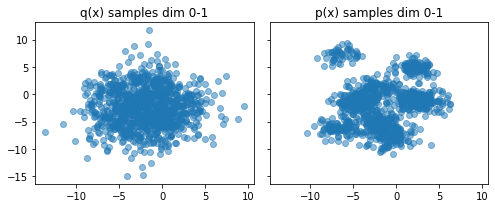

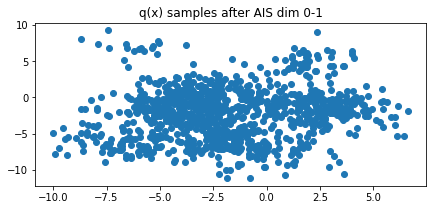

loss: 0.1931896609745813, mean log p_x -5.229512364177977:  40%|██████████████████████████████████▍                                                   | 40/100 [01:01<01:26,  1.44s/it]

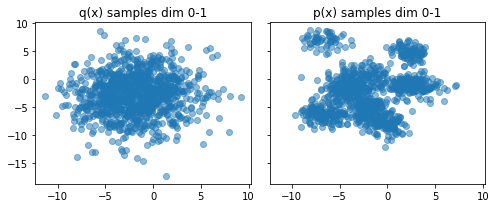

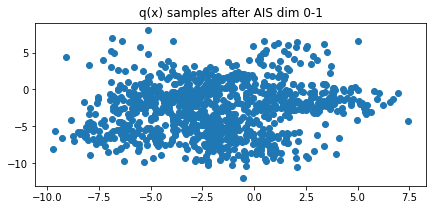

loss: 0.18239951227410917, mean log p_x -5.136920141807492:  50%|██████████████████████████████████████████▌                                          | 50/100 [01:17<01:10,  1.42s/it]

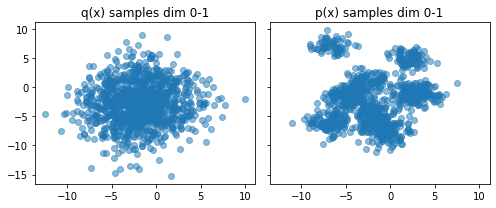

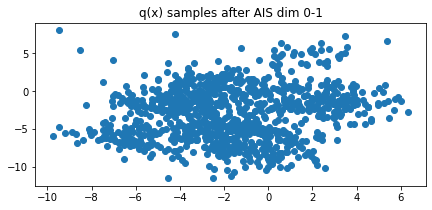

loss: 0.19368708328009054, mean log p_x -5.183876858607436:  60%|███████████████████████████████████████████████████                                  | 60/100 [01:33<00:58,  1.47s/it]

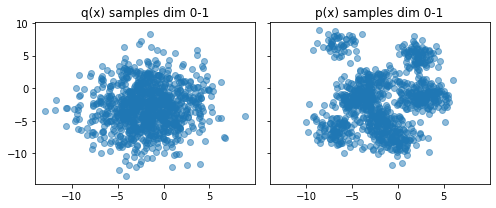

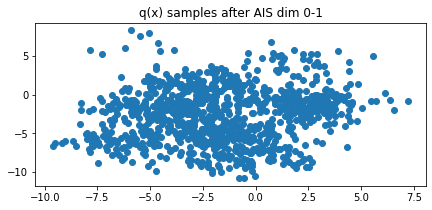

loss: 0.21021176129272065, mean log p_x -5.199226689115483:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [01:50<00:49,  1.64s/it]

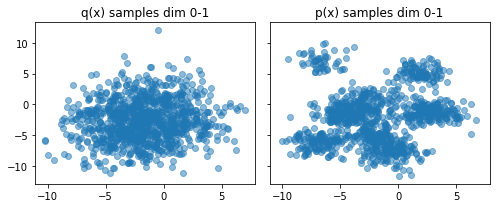

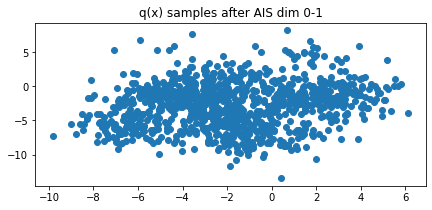

loss: 0.20985419669172856, mean log p_x -5.098480726223249:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [02:06<00:30,  1.53s/it]

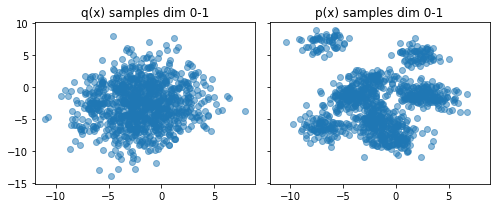

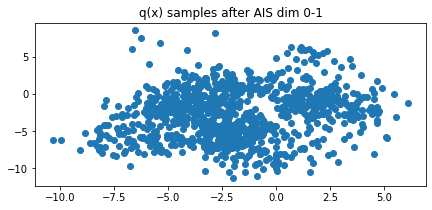

loss: 0.23238713787480766, mean log p_x -5.190874170500983:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [02:21<00:14,  1.41s/it]

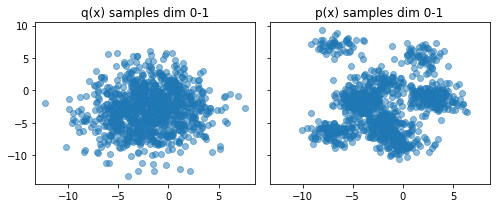

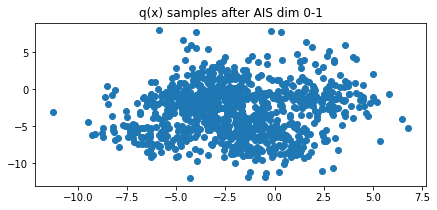

loss: 0.23238713787480766, mean log p_x -5.190874170500983: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


In [23]:
history = tester.train(100, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

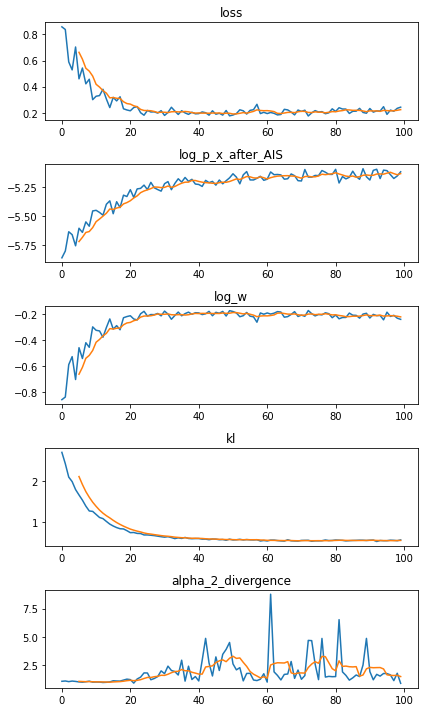

In [24]:
plot_history(history)

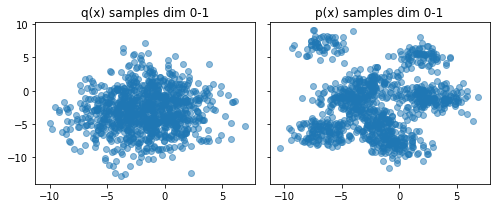

In [25]:
plot_samples(tester)

# Let's Try with HMC

In [6]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=5.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type="kl", n_distributions=20, n_steps_transition_operator=3,
                    step_size=1.0, transition_operator="HMC", train_AIS_params=True, learnt_dist_kwargs={"lr": 1e-3},
                    importance_param_lr=1e-3)

### Visualisation before training
Let's look at the effective sample size before training of vanilla IS vs annealed IS

In [7]:
n_samples_expectation = int(1e4)
n_samples=int(1e4)

In [8]:
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
expectation_vanilla, info_dict_vanilla = \
vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation_vanilla}")
print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
      var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

true expectation is 47.99143301277849, estimated expectation is 46.1627226682964
ESS is 0.3245991464779259,       var is 2.0809309205226756e-08


true expectation is 47.99143301277849, estimated expectation is 47.557910123336036
ESS is 0.7543667268276386, var is 3.256477656852466e-09


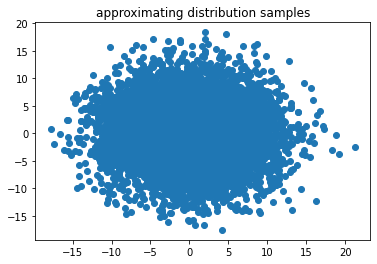

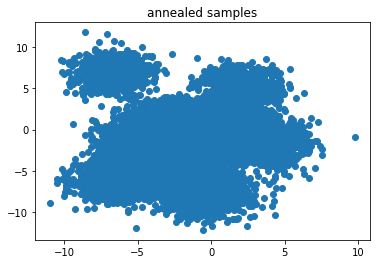

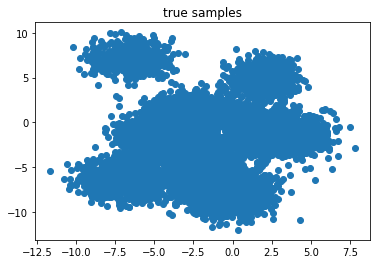

In [9]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(
    f"ESS is {info_dict['effective_sample_size'] / n_samples_expectation}, "
    f"var is {torch.var(info_dict['normalised_sampling_weights'])}")

plt.figure()
learnt_dist_samples = learnt_sampler.sample((n_samples,)).cpu().detach()
plt.scatter(learnt_dist_samples[:, 0], learnt_dist_samples[:, 1])
plt.title("approximating distribution samples")
plt.show()
plt.figure()
plt.scatter(info_dict["samples"][:, 0].cpu(), info_dict["samples"][:, 1].cpu())
plt.title("annealed samples")
plt.show()
plt.figure()
true_samples = target.sample((n_samples,)).cpu().detach()
plt.scatter(true_samples[:, 0], true_samples[:, 1])
plt.title("true samples")
plt.show()

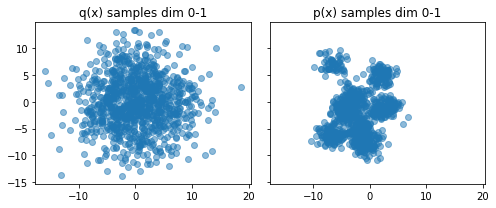

In [10]:
plot_samples(tester)

## Now let's train

In [53]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=5.0, flow_type="RealNVP", n_flow_steps=64)
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=3, n_steps_transition_operator=1,
                    step_size=0.5, transition_operator="HMC", train_AIS_params=True, learnt_dist_kwargs={"lr": 1e-4})
#tester.to("cpu")

TypeError: super(type, obj): obj must be an instance or subtype of type

In [54]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function)
print(info_dict_before['effective_sample_size'] / n_samples_expectation)

tensor(0.5635, device='cuda:0', grad_fn=<DivBackward0>)


loss: -1.2772205492710944, mean log p_x -8.369092233036156:   0%|          | 0/1000 [00:00<?, ?it/s]

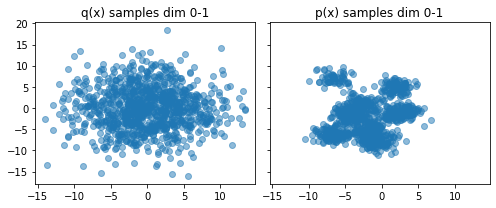

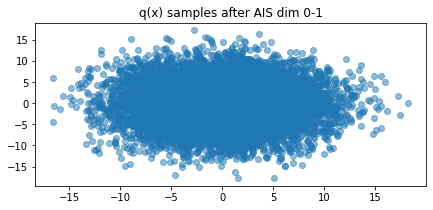

loss: -0.9061054678027305, mean log p_x -6.815808414350916:  33%|███▎      | 333/1000 [04:27<09:02,  1.23it/s] 

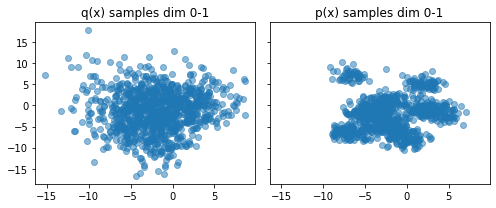

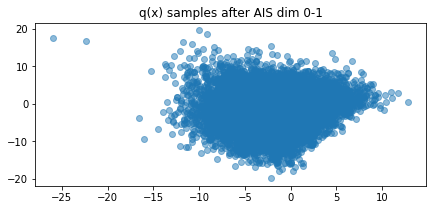

loss: -0.8204129957916397, mean log p_x -6.42977869572987:  67%|██████▋   | 666/1000 [09:00<04:25,  1.26it/s]  

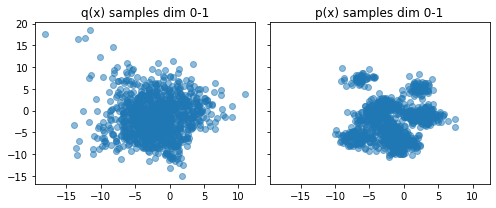

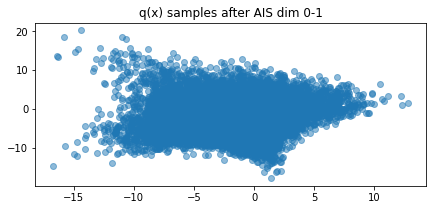

loss: -0.8411278904463695, mean log p_x -6.5743010274909235: 100%|█████████▉| 999/1000 [13:30<00:00,  1.22it/s]

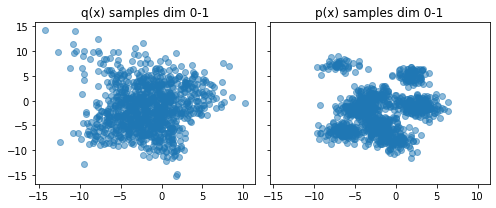

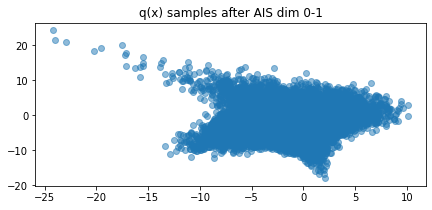

loss: -0.8411278904463695, mean log p_x -6.5743010274909235: 100%|██████████| 1000/1000 [13:31<00:00,  1.23it/s]


In [49]:
history = tester.train(1000, batch_size=int(1e4), intermediate_plots=True, n_plots=3, plotting_func=plotter)

In [50]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(f"ESS before is {info_dict_before['effective_sample_size'] / n_samples_expectation}, "
    f"var before is {torch.var(info_dict_before['normalised_sampling_weights'])} \n"
    f"ESS is {info_dict['effective_sample_size'] / n_samples_expectation}, "
    f"var is {torch.var(info_dict['normalised_sampling_weights'])}")

true expectation is 47.99143301277849, estimated expectation is 47.66201079630025
ESS before is 0.35613833843289233, var before is 1.8080784489656187e-08 
ESS is 0.554325841044778, var is 8.04073521668992e-09


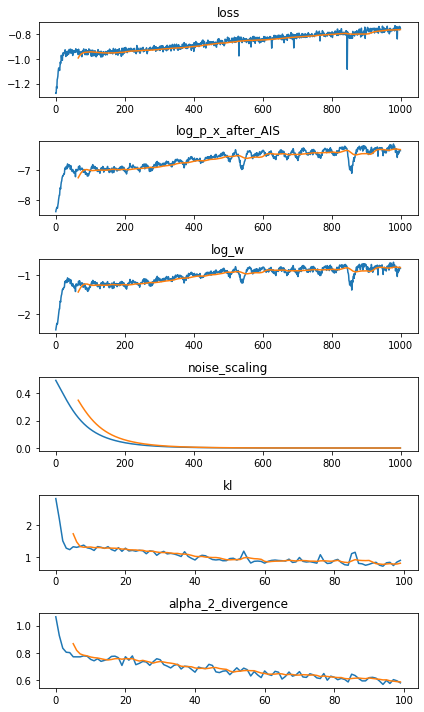

In [51]:
plot_history(history)

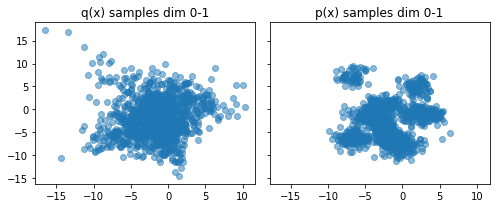

In [52]:
plot_samples(tester)

# Test DReG loss

In [85]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=5.0, flow_type="RealNVP", n_flow_steps=50)
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=20, n_updates_Metropolis=3,
                    noise_scaling=1.0, lr=1e-3)

loss: -0.7958904082490359, mean log p_x -5.958565441740005:   0%|                                                                                              | 0/100 [00:04<?, ?it/s]

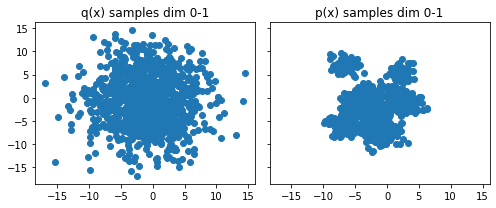

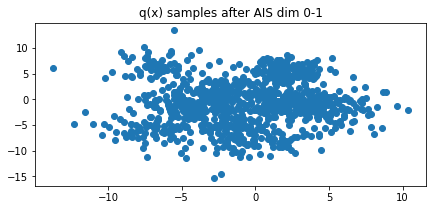

loss: -0.7759041322010622, mean log p_x -6.127116801048116:  10%|████████▌                                                                            | 10/100 [00:51<07:05,  4.73s/it]

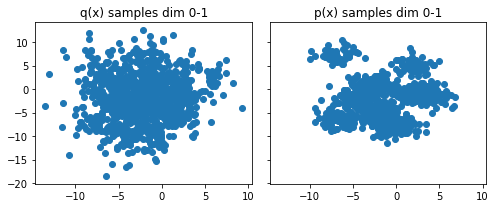

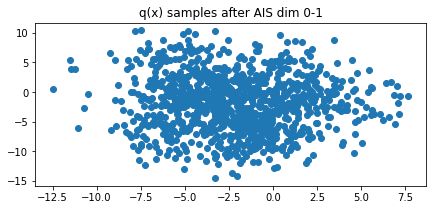

loss: -0.902032407420703, mean log p_x -7.034153334428182:  20%|█████████████████▏                                                                    | 20/100 [01:40<06:28,  4.85s/it]

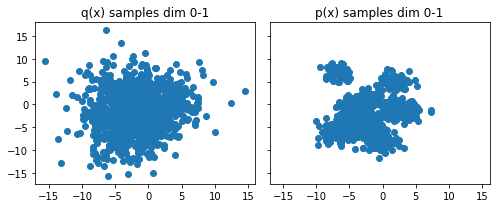

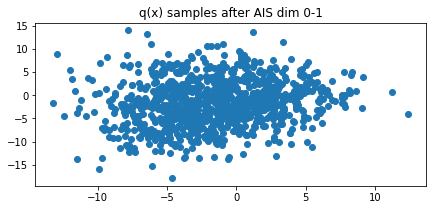

loss: -0.8820815956309614, mean log p_x -7.304737431472132:  30%|█████████████████████████▌                                                           | 30/100 [02:25<05:17,  4.53s/it]

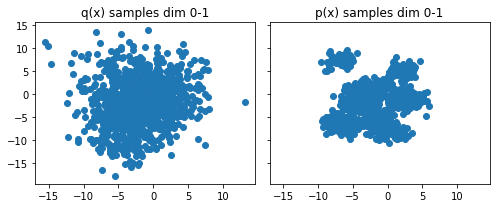

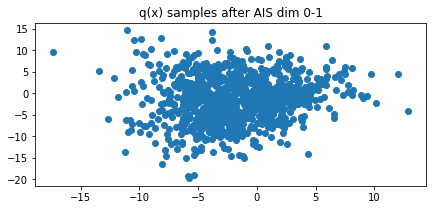

loss: -1.1806630641277076, mean log p_x -6.63738599832536:  40%|██████████████████████████████████▍                                                   | 40/100 [03:14<04:58,  4.98s/it]

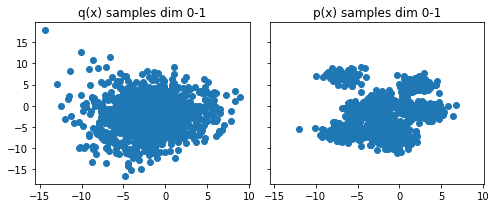

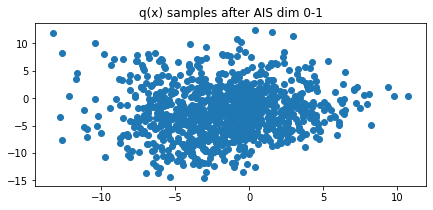

loss: -1.018825785644279, mean log p_x -6.520305149388003:  50%|███████████████████████████████████████████                                           | 50/100 [04:07<04:19,  5.19s/it]

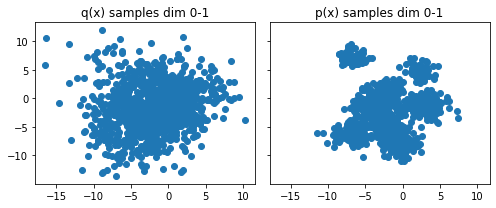

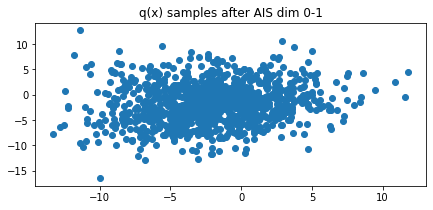

loss: -0.9093801698883648, mean log p_x -7.304702364506762:  60%|███████████████████████████████████████████████████                                  | 60/100 [04:58<03:12,  4.81s/it]

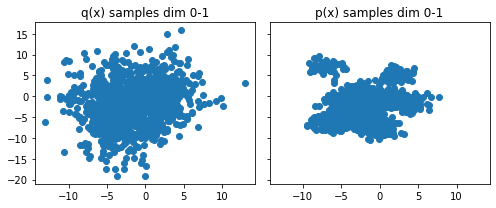

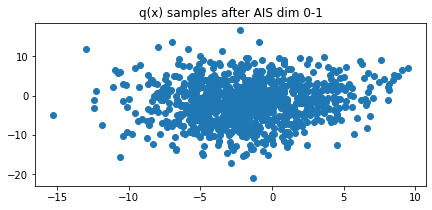

loss: -1.0151153862118183, mean log p_x -6.868970122666389:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [05:46<02:22,  4.75s/it]

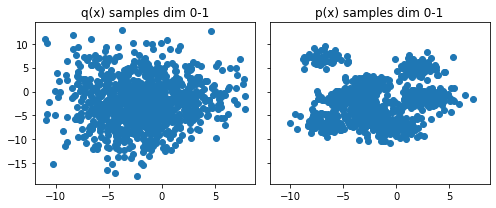

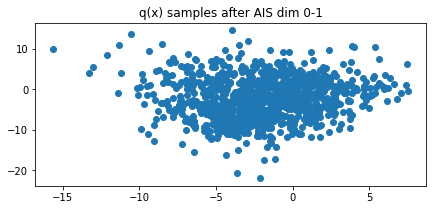

loss: -0.9072319213452169, mean log p_x -6.7457987503559735:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [06:32<01:30,  4.53s/it]

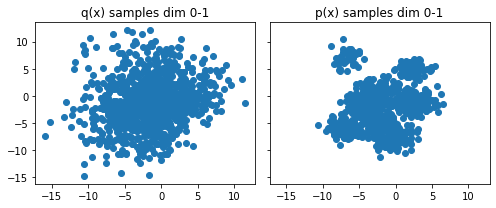

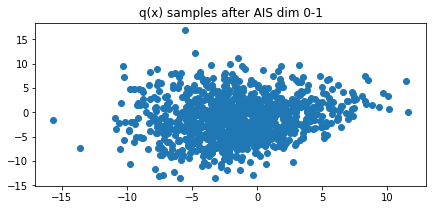

loss: -0.8982604295302783, mean log p_x -7.322312165580872:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [07:19<00:46,  4.69s/it]

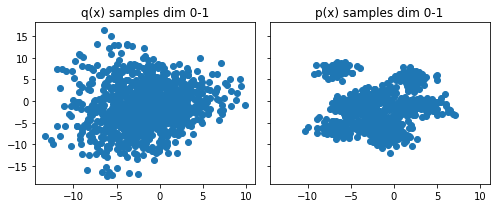

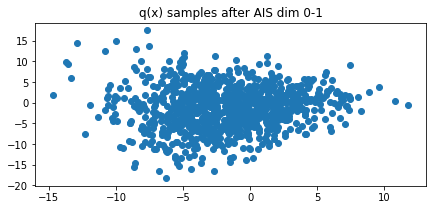

loss: -0.8982604295302783, mean log p_x -7.322312165580872: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:00<00:00,  4.81s/it]


In [86]:
history = tester.train(100, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

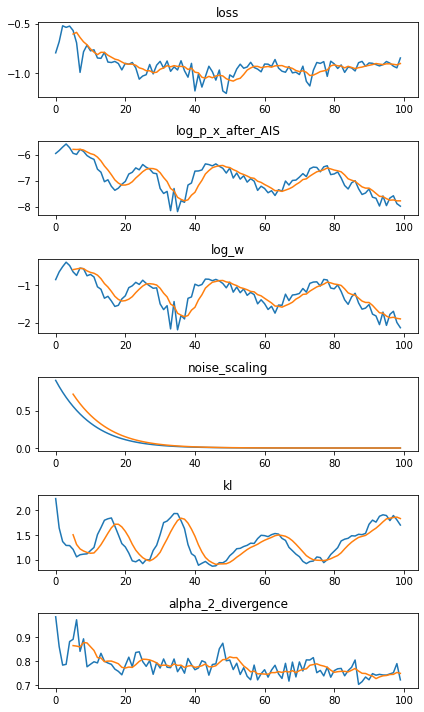

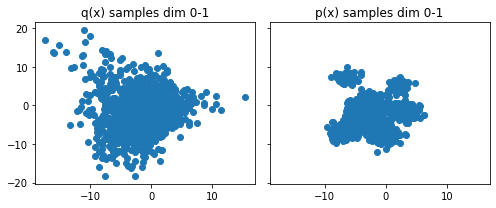

In [87]:
plot_history(history)
plot_samples(tester)

# Test var loss

In [20]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=5.0, flow_type="RealNVP", n_flow_steps=50)
tester = AIS_trainer(target, learnt_sampler, loss_type="kl", n_distributions=20, n_updates_Metropolis=3,
                    noise_scaling=1.0)

In [21]:
def var_loss(log_w):
    return torch.var(torch.exp(log_w))

In [22]:
tester.loss = var_loss

loss: 0.9278286954669456, mean log p_x -5.965693586630979:   0%|                                                                                               | 0/500 [00:04<?, ?it/s]

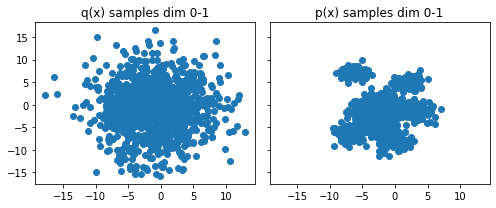

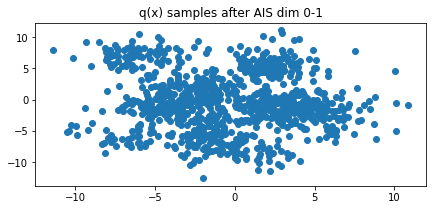

loss: 0.34004755711191226, mean log p_x -5.408625716228114:  10%|████████▌                                                                            | 50/500 [04:01<35:36,  4.75s/it]

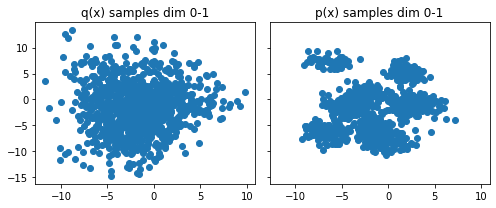

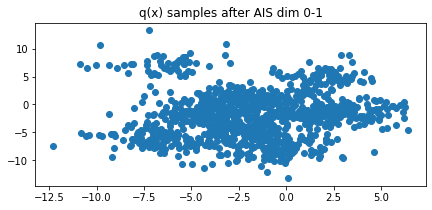

loss: 0.26326514717869237, mean log p_x -5.334466661049731:  20%|████████████████▊                                                                   | 100/500 [07:59<31:41,  4.75s/it]

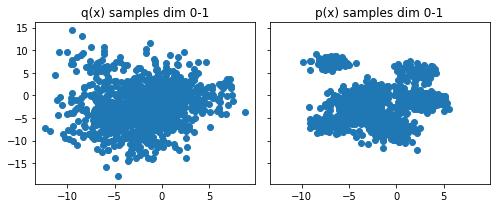

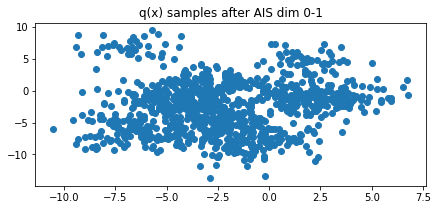

loss: 0.24218677436387878, mean log p_x -5.548106416311831:  30%|█████████████████████████▏                                                          | 150/500 [11:55<27:02,  4.64s/it]

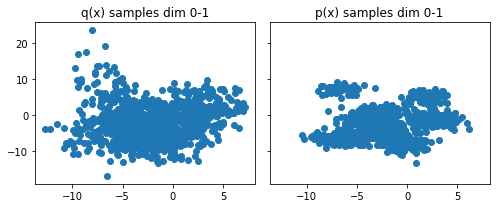

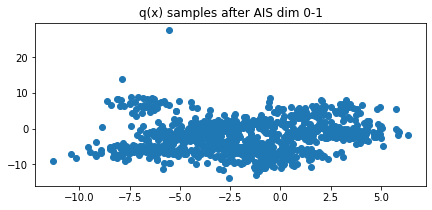

loss: 0.24218677436387878, mean log p_x -5.548106416311831:  32%|███████████████████████████                                                         | 161/500 [12:46<26:54,  4.76s/it]


ValueError: The value argument must be within the support

In [23]:
history = tester.train(500, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

loss: 0.20850268360087287, mean log p_x -5.353356675156009:   0%|                                                                                              | 0/500 [00:05<?, ?it/s]

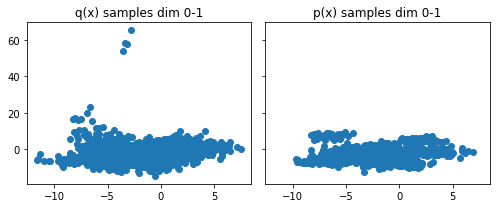

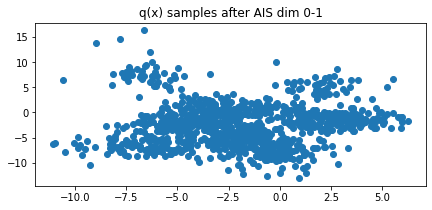

loss: 0.20850268360087287, mean log p_x -5.353356675156009:   1%|▌                                                                                     | 3/500 [00:15<42:31,  5.13s/it]


ValueError: The value argument must be within the support

In [24]:
history = tester.train(500, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

loss: 0.21757730258723326, mean log p_x -5.313804016759196:   0%|                                                                                              | 0/100 [00:04<?, ?it/s]

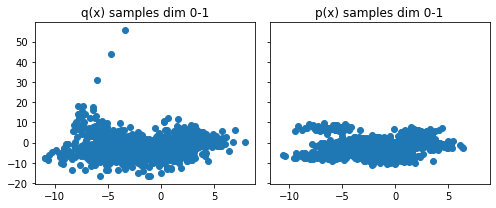

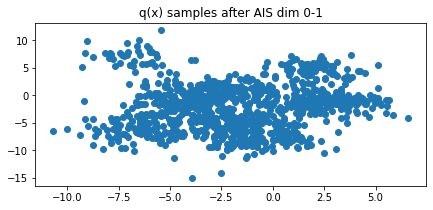

loss: 0.21757730258723326, mean log p_x -5.313804016759196:   9%|███████▋                                                                              | 9/100 [00:46<07:48,  5.15s/it]


ValueError: The value argument must be within the support

In [25]:
history = tester.train(100, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

loss: 0.18956851964725774, mean log p_x -5.343439078484879:   0%|                                                                                              | 0/100 [00:05<?, ?it/s]

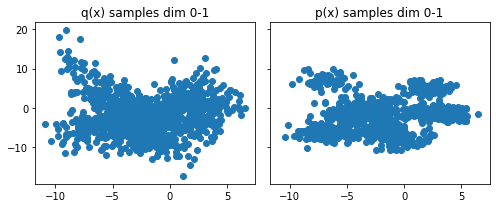

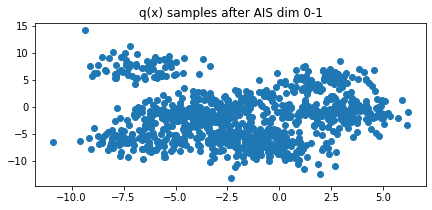

loss: 0.18956851964725774, mean log p_x -5.343439078484879:   8%|██████▉                                                                               | 8/100 [00:42<08:05,  5.28s/it]


ValueError: The value argument must be within the support

In [30]:
history = tester.train(100, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

loss: 0.16247463141982238, mean log p_x -5.187096226137449:   0%|                                                                                              | 0/100 [00:04<?, ?it/s]

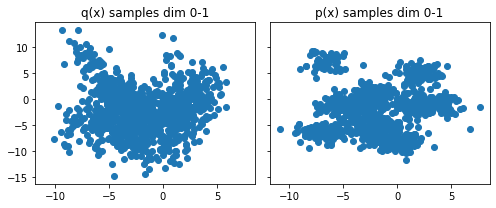

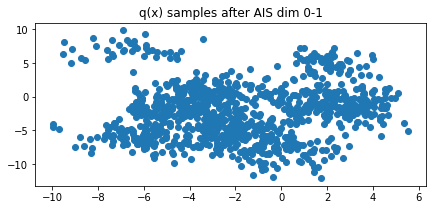

loss: 0.17230850495693528, mean log p_x -5.3166948282203625:  10%|████████▍                                                                           | 10/100 [00:54<07:20,  4.89s/it]

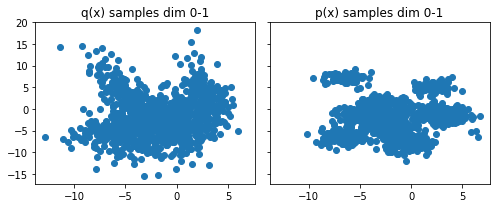

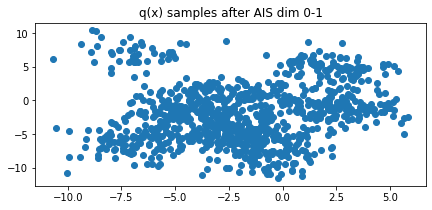

loss: 0.17230850495693528, mean log p_x -5.3166948282203625:  11%|█████████▏                                                                          | 11/100 [00:55<07:31,  5.07s/it]


ValueError: The value argument must be within the support

In [31]:
history = tester.train(100, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

loss: 0.15850442056216468, mean log p_x -5.222004690338963:   0%|                                                                                              | 0/100 [00:04<?, ?it/s]

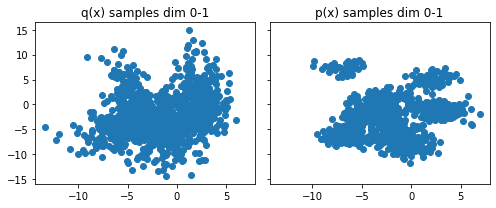

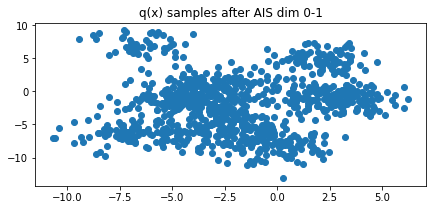

loss: 0.15942605551344635, mean log p_x -5.22413858516772:  10%|████████▌                                                                             | 10/100 [00:58<07:55,  5.28s/it]

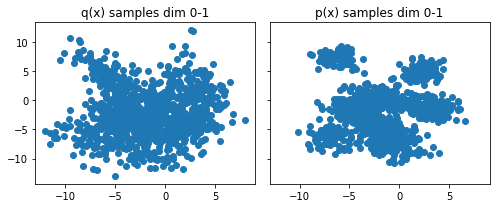

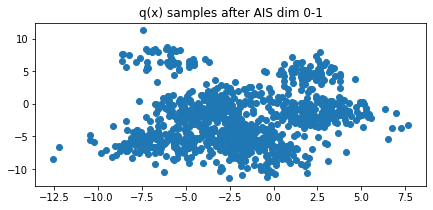

loss: 0.15942605551344635, mean log p_x -5.22413858516772:  16%|█████████████▊                                                                        | 16/100 [01:26<07:34,  5.41s/it]


ValueError: The value argument must be within the support

In [32]:
history = tester.train(100, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

In [35]:
tester.AIS_train.noise_scaling

tensor([1.2584], grad_fn=<ExpBackward>)

loss: 0.16453197505562522, mean log p_x -5.2686310917511205:   0%|                                                                                              | 0/10 [00:04<?, ?it/s]

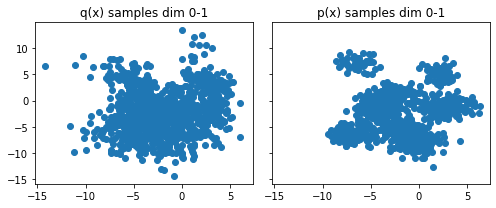

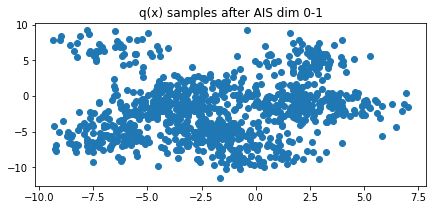

loss: 0.15888101393749535, mean log p_x -5.240883934632674:  10%|████████▋                                                                              | 1/10 [00:10<00:49,  5.48s/it]

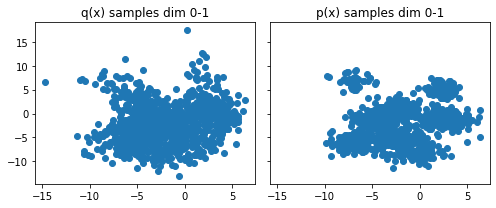

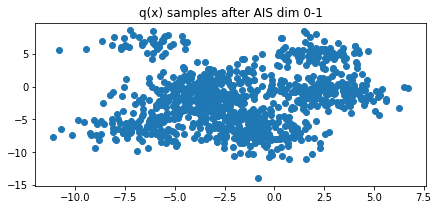

loss: 0.16053055499122243, mean log p_x -5.258943265101732:  20%|█████████████████▍                                                                     | 2/10 [00:16<00:44,  5.59s/it]

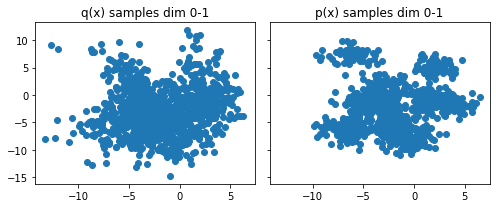

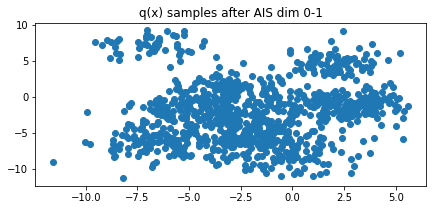

loss: 0.1552469893355658, mean log p_x -5.228356205709029:  30%|██████████████████████████▍                                                             | 3/10 [00:22<00:39,  5.69s/it]

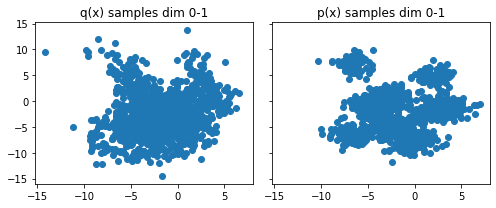

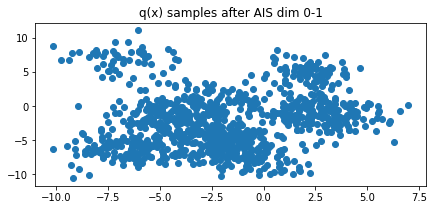

loss: 0.16168017265638654, mean log p_x -5.2685578122021495:  40%|██████████████████████████████████▍                                                   | 4/10 [00:28<00:34,  5.70s/it]

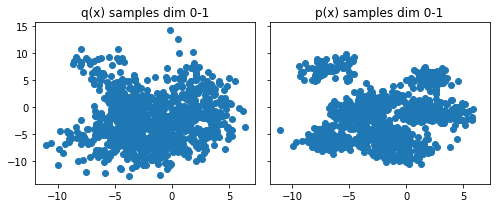

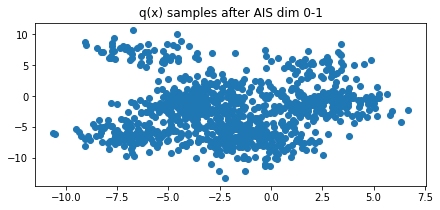

loss: 0.15817097284874362, mean log p_x -5.263009288904245:  50%|███████████████████████████████████████████▌                                           | 5/10 [00:35<00:30,  6.02s/it]

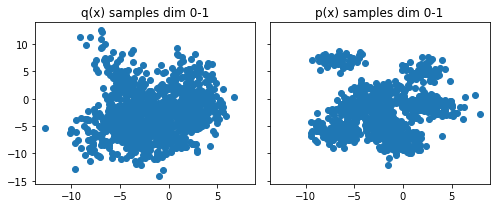

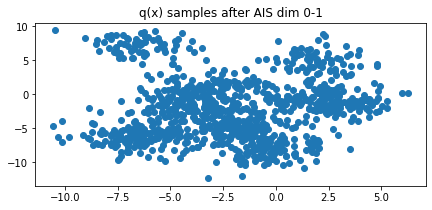

loss: 0.14300342142557804, mean log p_x -5.204596003465901:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:40<00:24,  6.05s/it]

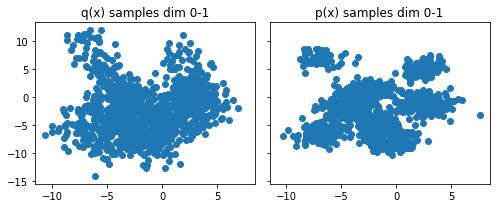

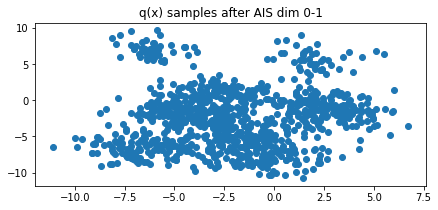

loss: 0.1448524871760339, mean log p_x -5.2154923310343015:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:46<00:17,  5.88s/it]

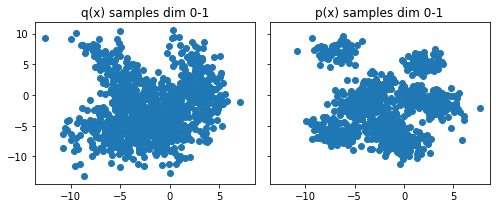

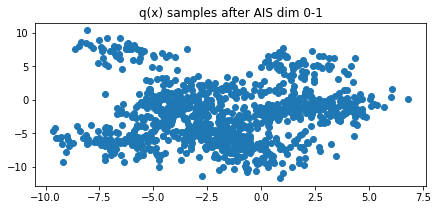

loss: 0.14198116935707958, mean log p_x -5.159418036890987:  80%|█████████████████████████████████████████████████████████████████████▌                 | 8/10 [00:51<00:11,  5.74s/it]

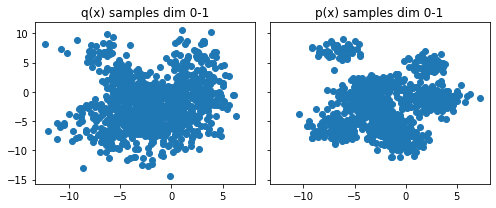

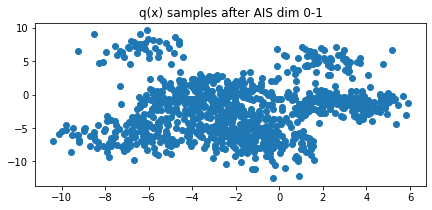

loss: 0.15115163747505153, mean log p_x -5.264564254096701:  90%|██████████████████████████████████████████████████████████████████████████████▎        | 9/10 [00:57<00:05,  5.64s/it]

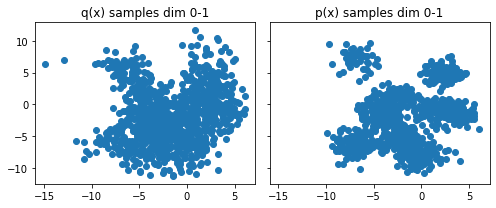

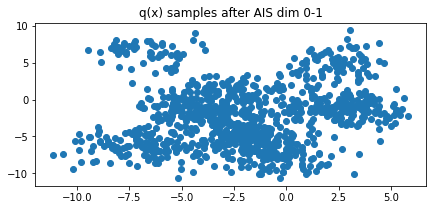

loss: 0.15115163747505153, mean log p_x -5.264564254096701: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.78s/it]


In [36]:
history = tester.train(10, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

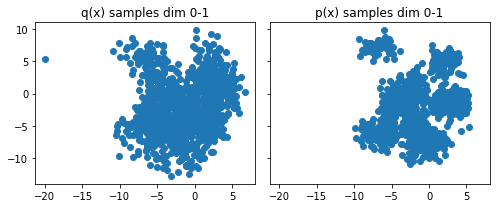

In [37]:
plot_samples(tester)

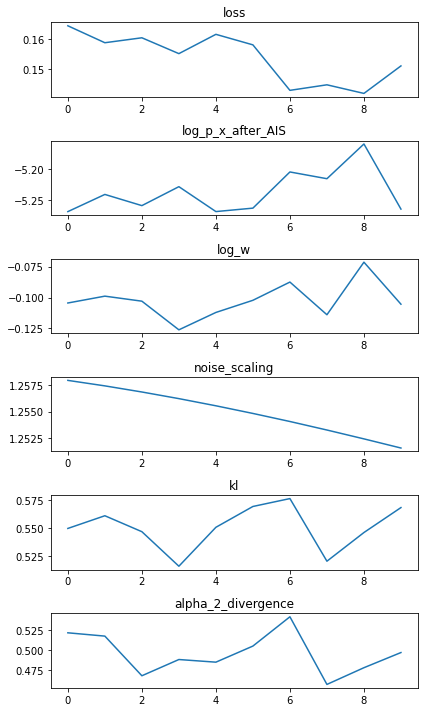

In [38]:
plot_history(history)

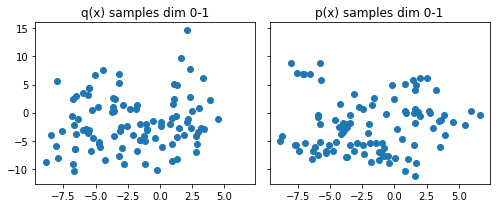

In [39]:
plot_samples(tester, n_samples=100)

loss: 0.16834540703294784, mean log p_x -5.293641700276373:   0%|                                                                                               | 0/10 [00:05<?, ?it/s]

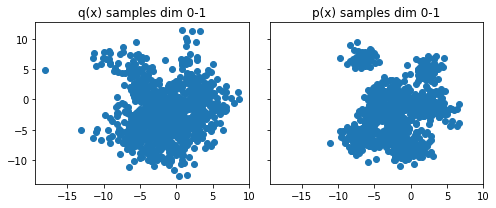

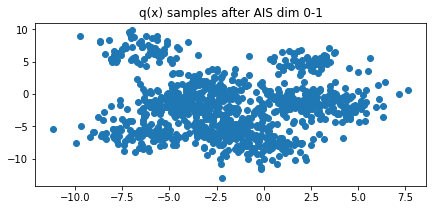

loss: 0.1885571750780424, mean log p_x -5.254637872129827:  10%|████████▊                                                                               | 1/10 [00:11<00:53,  5.95s/it]

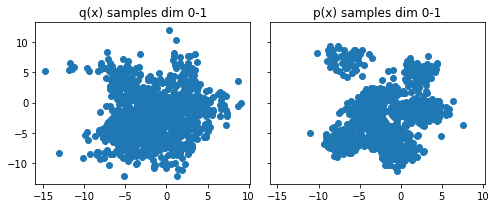

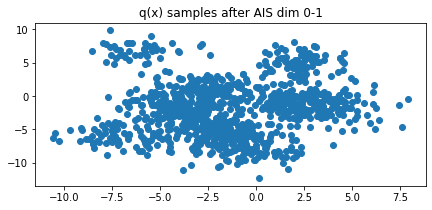

loss: 0.191651009093209, mean log p_x -5.225634972151051:  20%|█████████████████▊                                                                       | 2/10 [00:17<00:47,  5.90s/it]

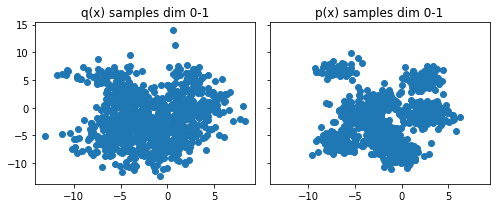

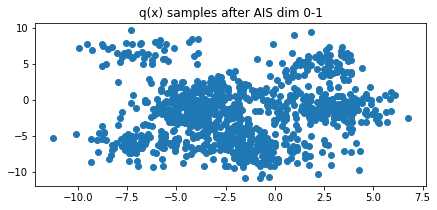

loss: 0.16607675213562015, mean log p_x -5.267353677470885:  30%|██████████████████████████                                                             | 3/10 [00:23<00:42,  6.05s/it]

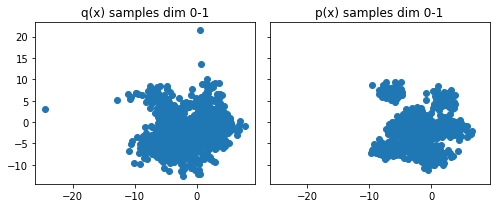

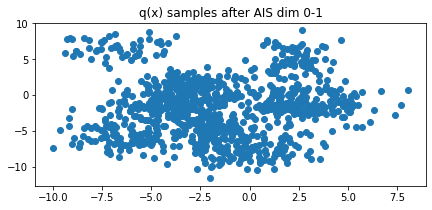

loss: 0.17420557883200088, mean log p_x -5.252560095127159:  40%|██████████████████████████████████▊                                                    | 4/10 [00:28<00:35,  5.94s/it]

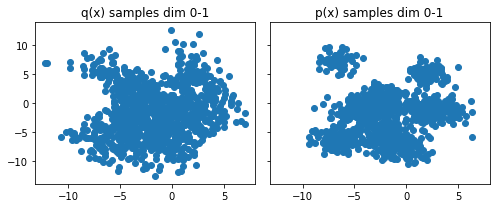

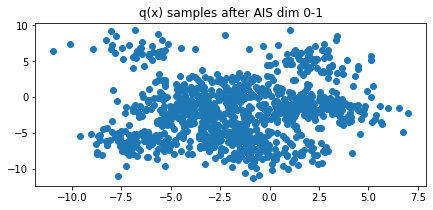

loss: 0.1496059799457554, mean log p_x -5.202740790448418:  50%|████████████████████████████████████████████                                            | 5/10 [00:34<00:29,  5.89s/it]

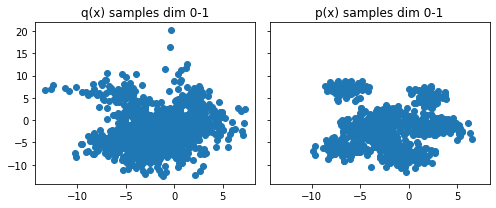

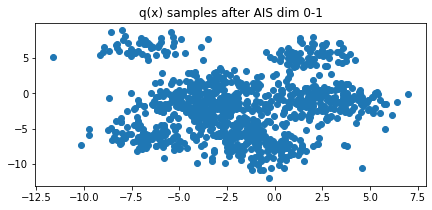

loss: 0.16341295163195474, mean log p_x -5.304920894275632:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:40<00:23,  5.79s/it]

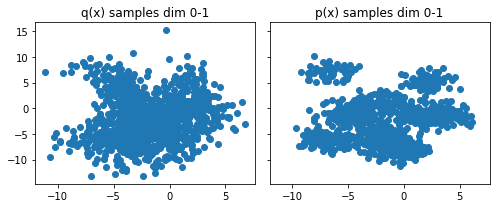

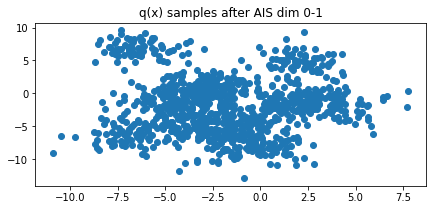

loss: 0.15772379538591308, mean log p_x -5.230338696507794:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:46<00:17,  5.75s/it]

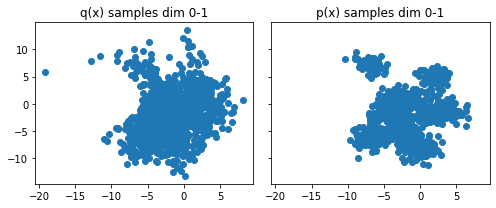

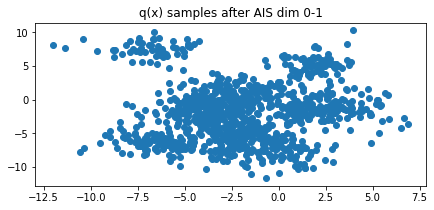

loss: 0.18820339957495616, mean log p_x -5.255543640087879:  80%|█████████████████████████████████████████████████████████████████████▌                 | 8/10 [00:52<00:11,  5.84s/it]

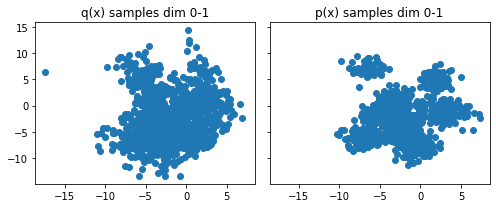

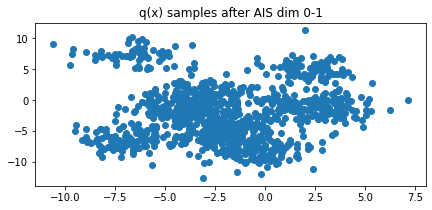

loss: 0.18262378720810146, mean log p_x -5.447646084555092:  90%|██████████████████████████████████████████████████████████████████████████████▎        | 9/10 [00:57<00:05,  5.91s/it]

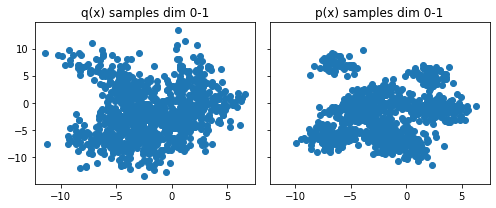

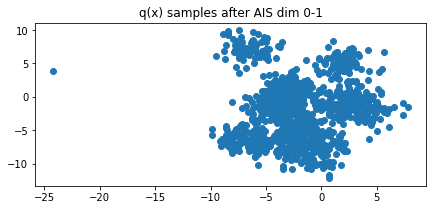

loss: 0.18262378720810146, mean log p_x -5.447646084555092: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.85s/it]


In [42]:
history = tester.train(10, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

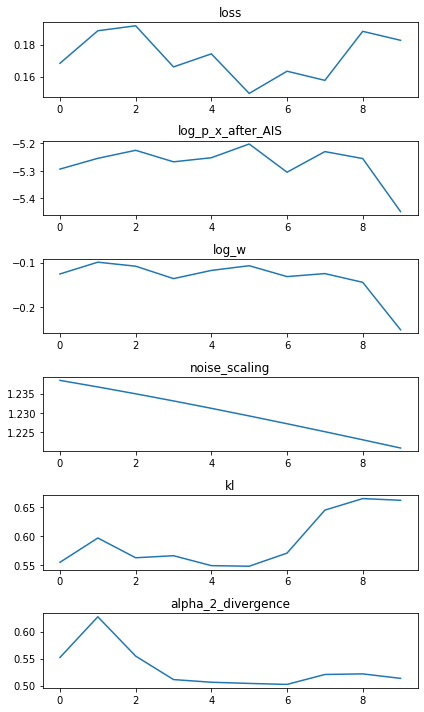

In [43]:
plot_history(history)

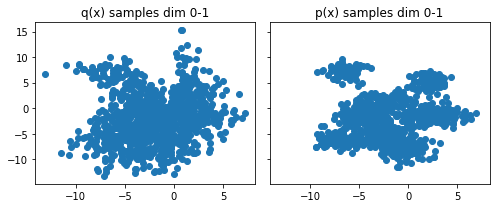

In [44]:
plot_samples(tester)

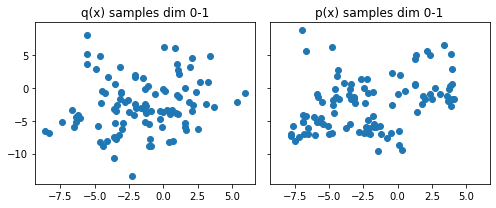

In [45]:
plot_samples(tester, n_samples=100)

loss: 0.15759565611493612, mean log p_x -5.265484600821476:   0%|                                                                                               | 0/10 [00:05<?, ?it/s]

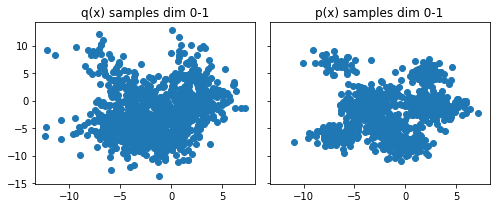

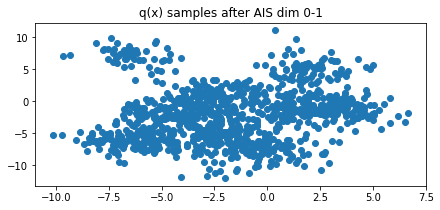

loss: 0.15851728940668525, mean log p_x -5.223245723780813:  10%|████████▋                                                                              | 1/10 [00:11<00:52,  5.83s/it]

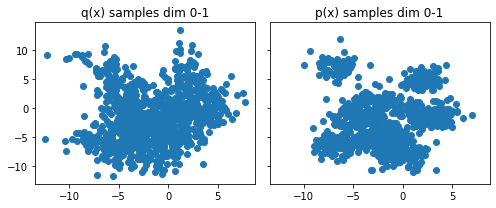

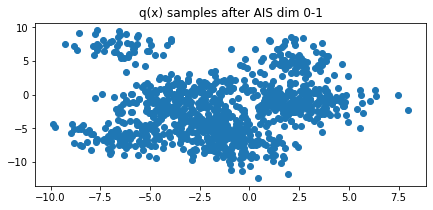

loss: 0.15382636768325408, mean log p_x -5.286410348733912:  20%|█████████████████▍                                                                     | 2/10 [00:17<00:46,  5.85s/it]

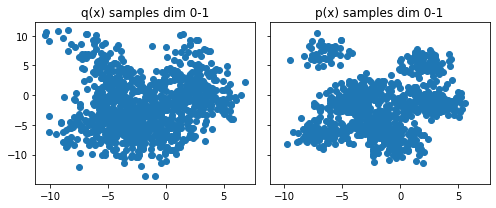

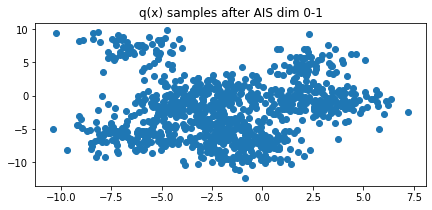

loss: 0.1492044421139961, mean log p_x -5.267359284302595:  30%|██████████████████████████▍                                                             | 3/10 [00:22<00:41,  5.88s/it]

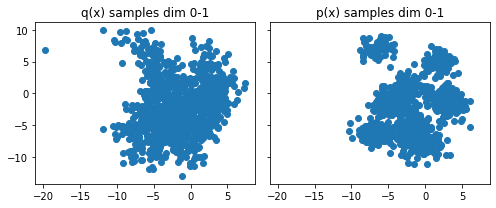

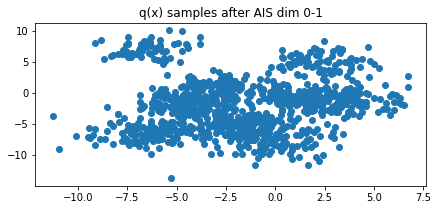

loss: 0.1498988956409573, mean log p_x -5.343306638527635:  40%|███████████████████████████████████▏                                                    | 4/10 [00:28<00:34,  5.73s/it]

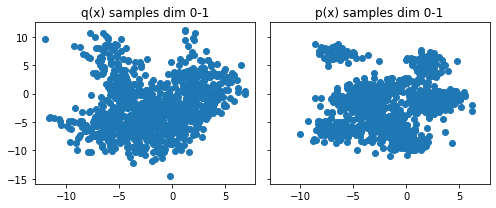

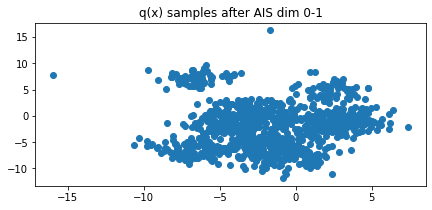

loss: 0.1478612383644184, mean log p_x -5.2979477163144635:  50%|███████████████████████████████████████████▌                                           | 5/10 [00:34<00:29,  5.87s/it]

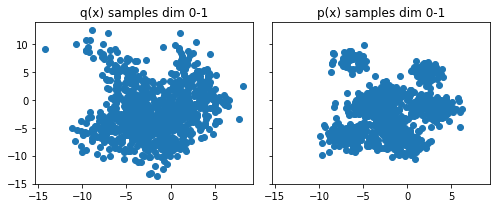

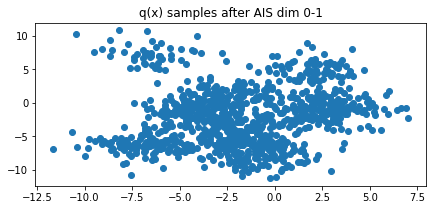

loss: 0.1610317192764348, mean log p_x -5.273057067416259:  60%|████████████████████████████████████████████████████▊                                   | 6/10 [00:40<00:23,  5.94s/it]

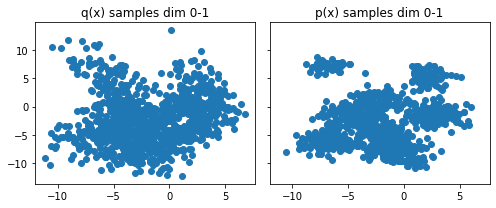

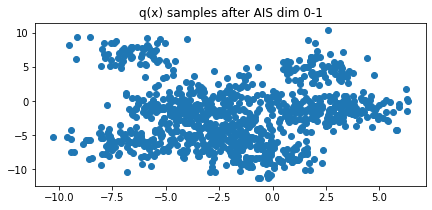

loss: 0.14500928102125332, mean log p_x -5.234924087784581:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:45<00:17,  5.88s/it]

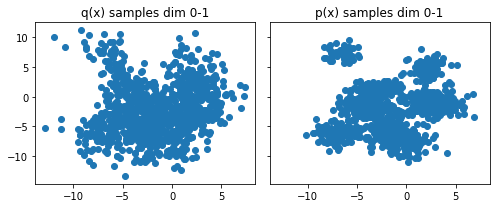

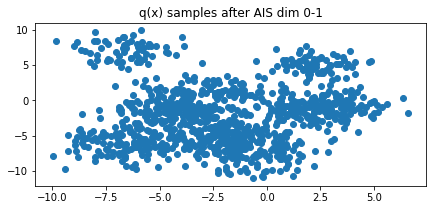

loss: 0.14020024084299332, mean log p_x -5.216041895168196:  80%|█████████████████████████████████████████████████████████████████████▌                 | 8/10 [00:51<00:11,  5.72s/it]

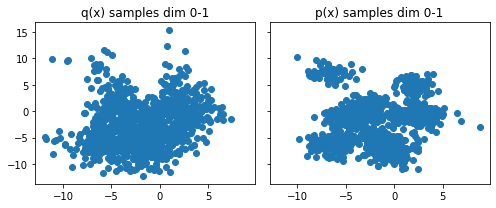

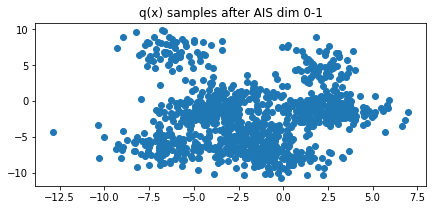

loss: 0.15459469686943006, mean log p_x -5.25634682847659:  90%|███████████████████████████████████████████████████████████████████████████████▏        | 9/10 [00:56<00:05,  5.66s/it]

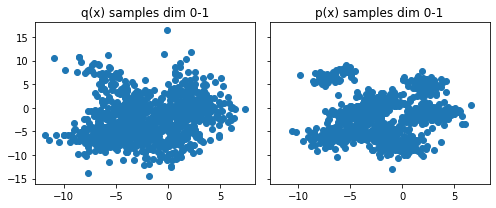

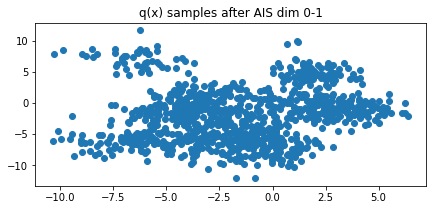

loss: 0.15459469686943006, mean log p_x -5.25634682847659: 100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.72s/it]


In [47]:
history = tester.train(10, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

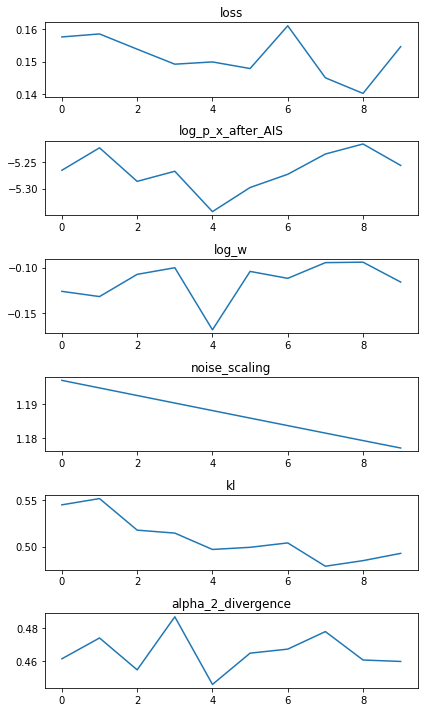

In [48]:
plot_history(history)

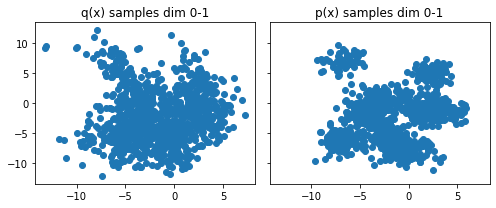

In [49]:
plot_samples(tester)

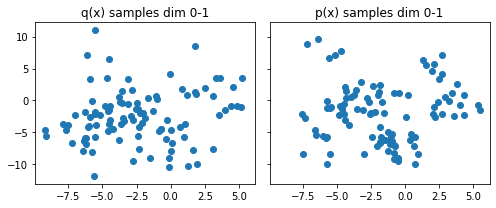

In [50]:
plot_samples(tester, n_samples=100)

## Let's manually decrease the noise, as it seems like this is the consistent movement

In [56]:
tester.AIS_train.log_noise_scaling.data = torch.tensor([-0.5])

loss: 0.22790390633882404, mean log p_x -5.347575973746008:   0%|                                                                                               | 0/20 [00:04<?, ?it/s]

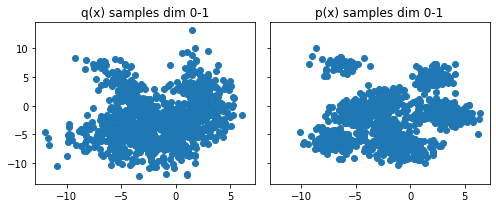

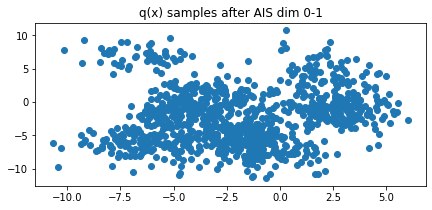

loss: 0.2401962184942394, mean log p_x -5.3221212831182045:  10%|████████▋                                                                              | 2/20 [00:15<01:37,  5.40s/it]

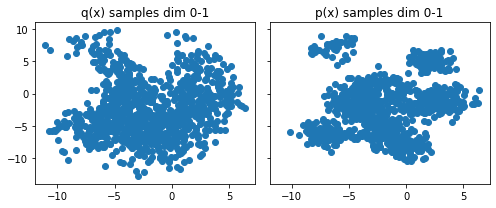

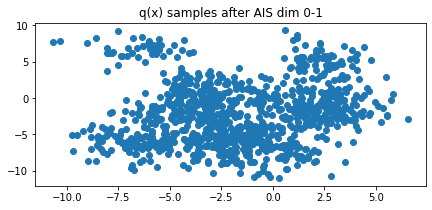

loss: 0.2401962184942394, mean log p_x -5.3221212831182045:  20%|█████████████████▍                                                                     | 4/20 [00:22<01:29,  5.59s/it]


ValueError: The value argument must be within the support

In [57]:
history = tester.train(20, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

loss: 0.2128558582794883, mean log p_x -5.375066812092988:   0%|                                                                                                | 0/20 [00:05<?, ?it/s]

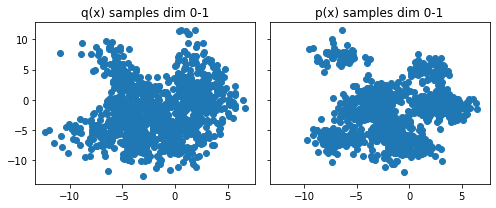

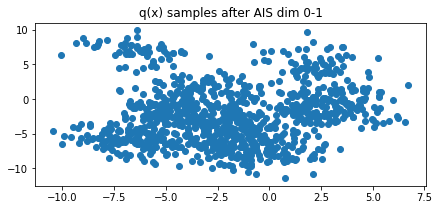

loss: 0.22698470255202813, mean log p_x -5.385219904182676:  10%|████████▋                                                                              | 2/20 [00:15<01:37,  5.41s/it]

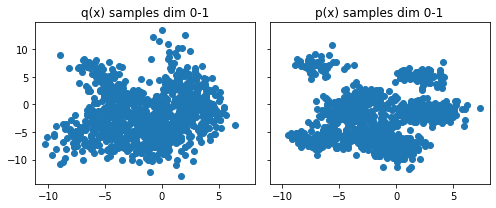

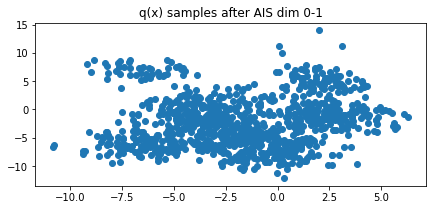

loss: 0.2424677773715522, mean log p_x -5.440094731106376:  20%|█████████████████▌                                                                      | 4/20 [00:25<01:25,  5.31s/it]

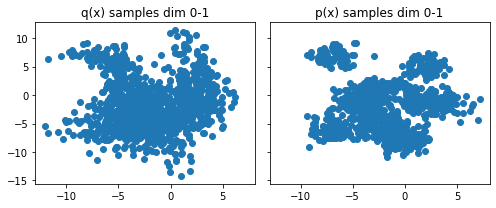

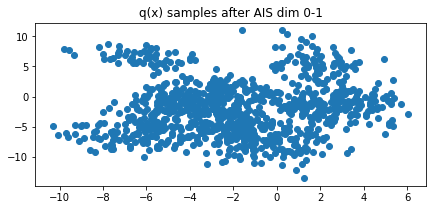

loss: 0.24261192327201736, mean log p_x -5.402081646207644:  30%|██████████████████████████                                                             | 6/20 [00:36<01:13,  5.25s/it]

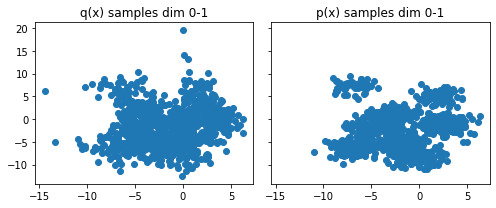

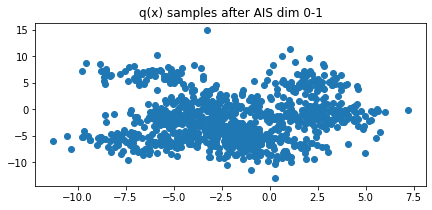

loss: 0.23921476740697967, mean log p_x -5.430583977915172:  40%|██████████████████████████████████▊                                                    | 8/20 [00:47<01:03,  5.33s/it]

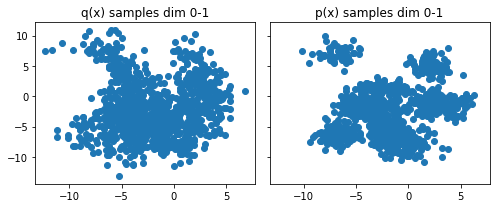

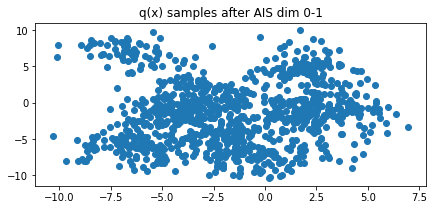

loss: 0.24036499636799882, mean log p_x -5.3749360598691:  50%|████████████████████████████████████████████                                            | 10/20 [00:58<00:54,  5.49s/it]

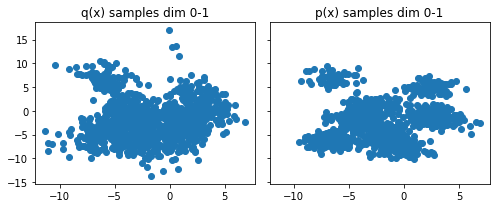

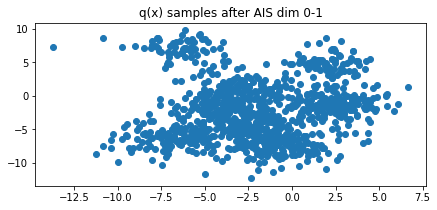

loss: 0.21995868875548702, mean log p_x -5.293683021772868:  60%|███████████████████████████████████████████████████▌                                  | 12/20 [01:09<00:43,  5.45s/it]

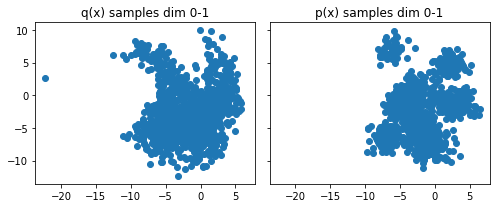

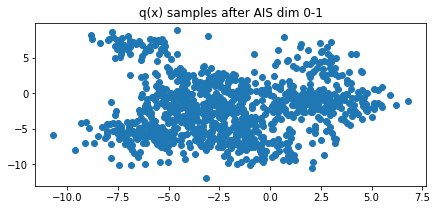

loss: 0.3009818444438938, mean log p_x -5.338013204373675:  70%|████████████████████████████████████████████████████████████▉                          | 14/20 [01:20<00:32,  5.38s/it]

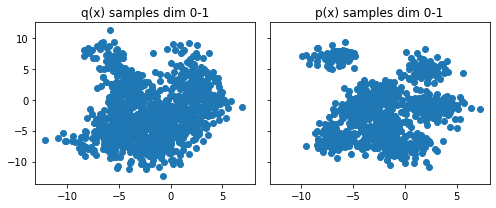

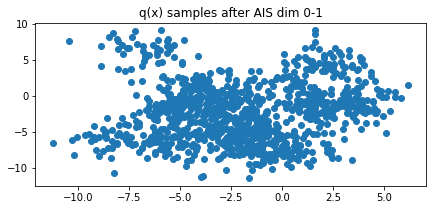

loss: 0.2662004598521834, mean log p_x -5.390316661875022:  80%|█████████████████████████████████████████████████████████████████████▌                 | 16/20 [01:30<00:21,  5.41s/it]

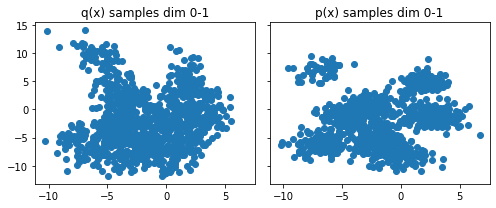

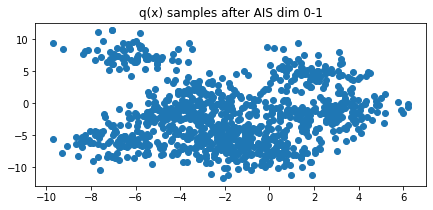

loss: 0.31233706824097274, mean log p_x -5.4576546510087445:  90%|████████████████████████████████████████████████████████████████████████████▌        | 18/20 [01:40<00:10,  5.18s/it]

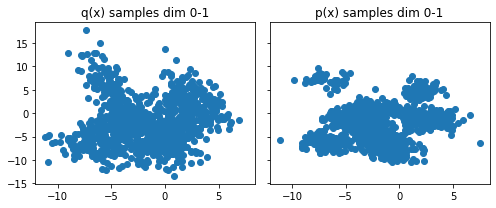

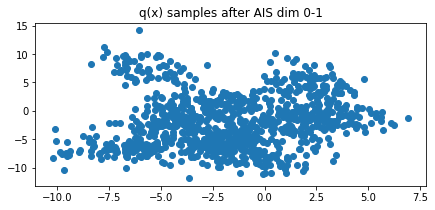

loss: 0.31233706824097274, mean log p_x -5.4576546510087445: 100%|█████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:46<00:00,  5.32s/it]


In [58]:
history = tester.train(20, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

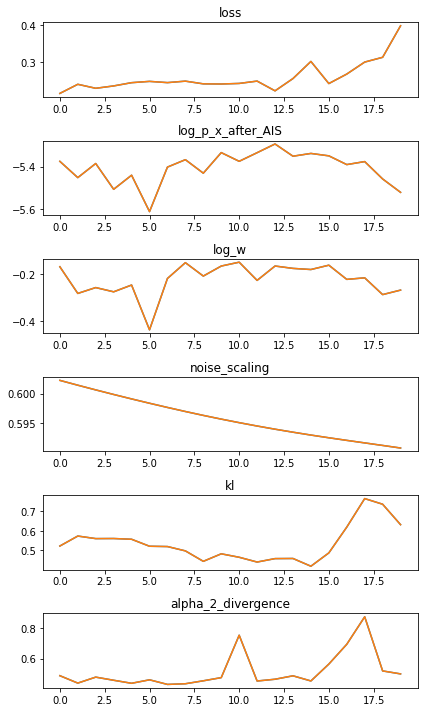

In [59]:
plot_history(history)

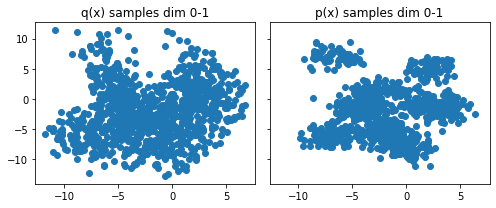

In [60]:
plot_samples(tester)

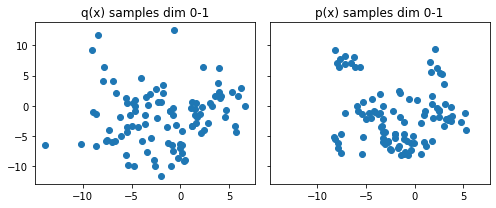

In [61]:
plot_samples(tester, n_samples=100)

loss: 0.29171209481254706, mean log p_x -5.609088076922133:   0%|                                                                                               | 0/30 [00:05<?, ?it/s]

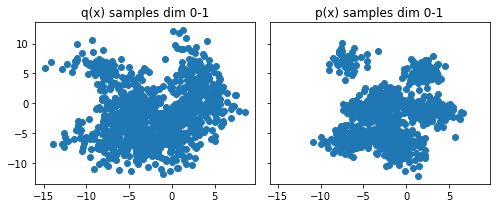

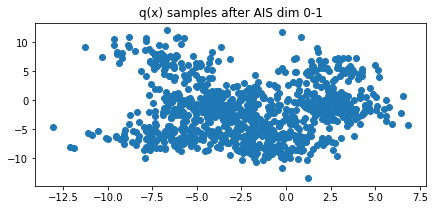

loss: 0.40098165617221865, mean log p_x -5.653111312168361:  10%|████████▋                                                                              | 3/30 [00:21<02:28,  5.49s/it]

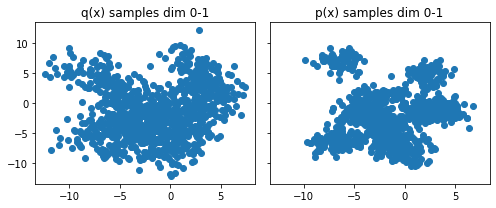

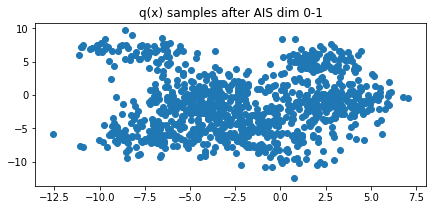

loss: 0.2960488494300181, mean log p_x -5.50038286657961:  20%|█████████████████▊                                                                       | 6/30 [00:38<02:17,  5.73s/it]

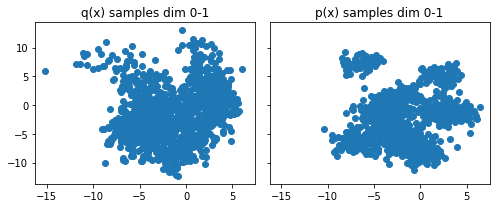

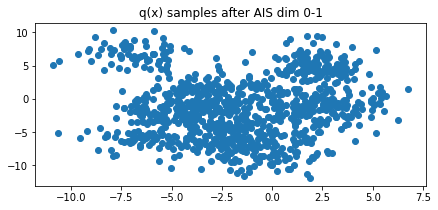

loss: 0.27963989128523875, mean log p_x -5.513168761702043:  30%|██████████████████████████                                                             | 9/30 [00:55<01:55,  5.48s/it]

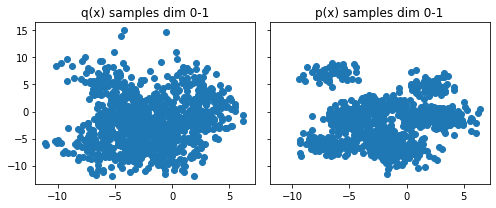

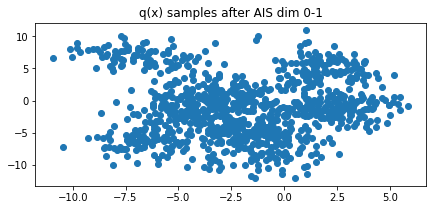

loss: 0.5210898583870869, mean log p_x -5.947916732382022:  40%|██████████████████████████████████▊                                                    | 12/30 [01:11<01:37,  5.42s/it]

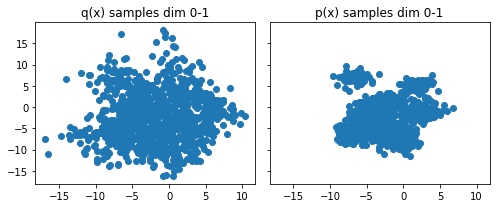

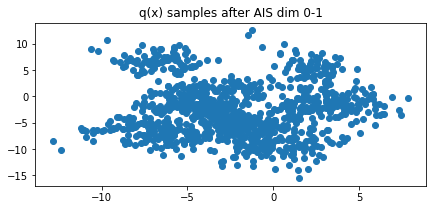

loss: 0.6490108005358924, mean log p_x -6.288289409624716:  50%|███████████████████████████████████████████▌                                           | 15/30 [01:29<01:26,  5.76s/it]

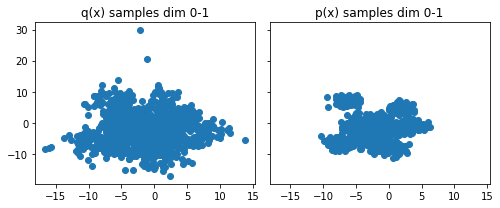

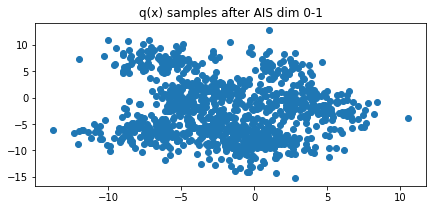

loss: 0.4559096116006063, mean log p_x -5.886864600512751:  60%|████████████████████████████████████████████████████▏                                  | 18/30 [01:47<01:07,  5.61s/it]

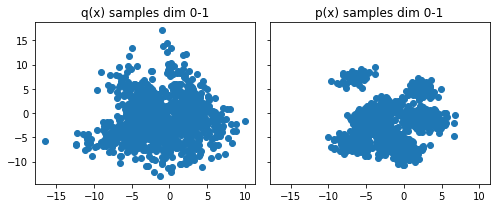

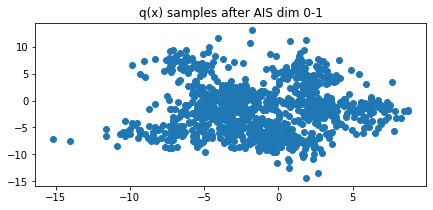

loss: 0.4888626103537084, mean log p_x -5.514176507245449:  70%|████████████████████████████████████████████████████████████▉                          | 21/30 [02:06<00:55,  6.13s/it]

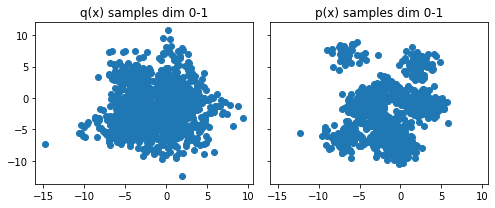

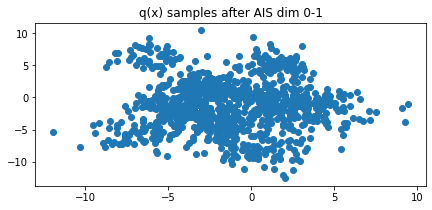

loss: 0.38170468383920503, mean log p_x -5.400078560388037:  80%|████████████████████████████████████████████████████████████████████▊                 | 24/30 [02:24<00:35,  5.99s/it]

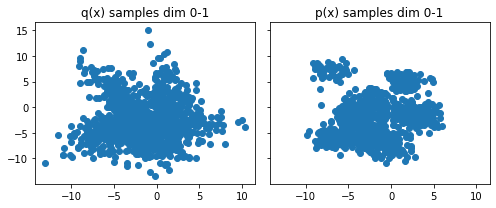

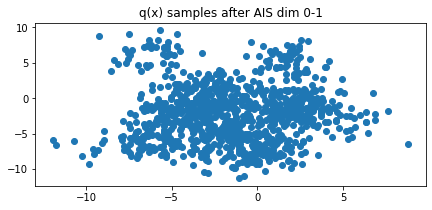

loss: 0.3418470425551688, mean log p_x -5.507191050660334:  90%|██████████████████████████████████████████████████████████████████████████████▎        | 27/30 [02:41<00:17,  5.76s/it]

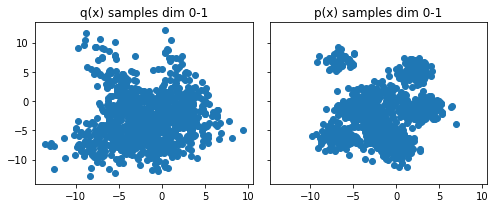

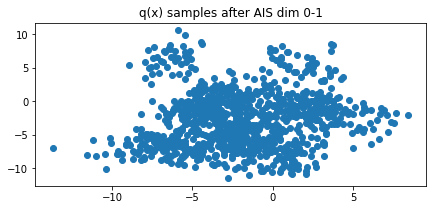

loss: 0.3418470425551688, mean log p_x -5.507191050660334: 100%|███████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:54<00:00,  5.80s/it]


In [62]:
history = tester.train(30, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

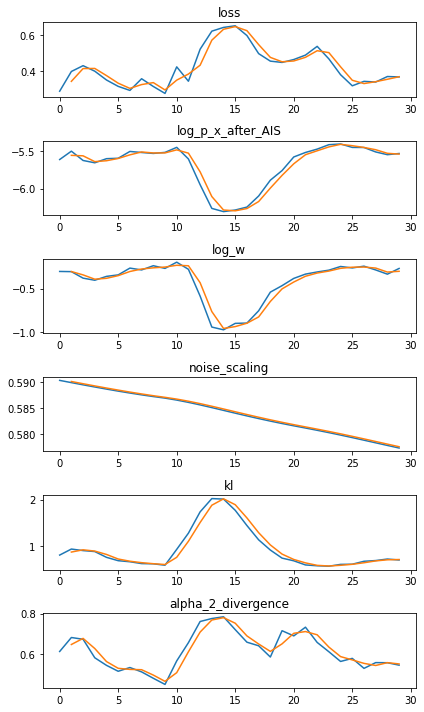

In [63]:
plot_history(history)

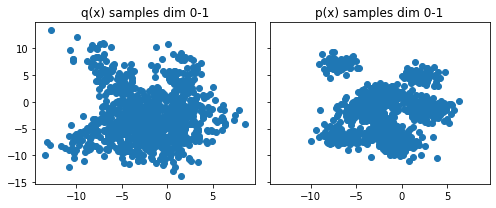

In [64]:
plot_samples(tester)

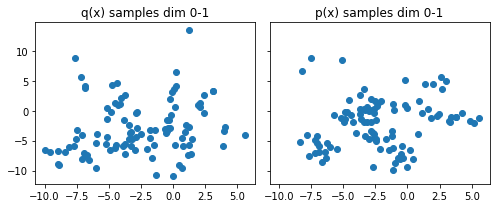

In [65]:
plot_samples(tester, n_samples=100)

In [66]:
tester.AIS_train.log_noise_scaling.data = torch.tensor([-1.0])

loss: 0.44506974466966737, mean log p_x -5.780672502729397:   0%|                                                                                               | 0/30 [00:05<?, ?it/s]

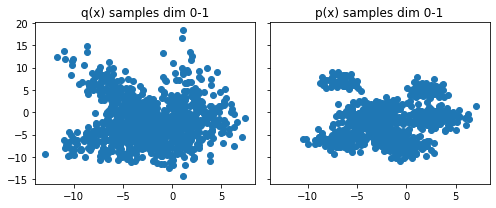

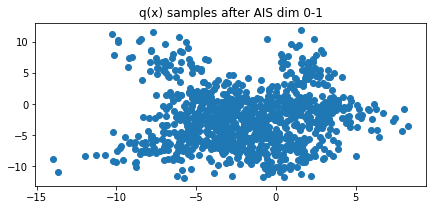

loss: 0.42231666317655175, mean log p_x -5.844896499536136:  10%|████████▋                                                                              | 3/30 [00:23<02:32,  5.64s/it]

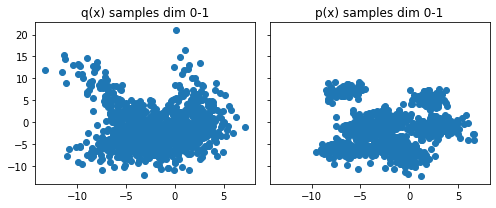

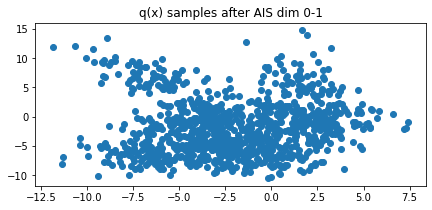

loss: 0.39986944413851483, mean log p_x -5.644407406314681:  20%|█████████████████▍                                                                     | 6/30 [00:41<02:26,  6.12s/it]

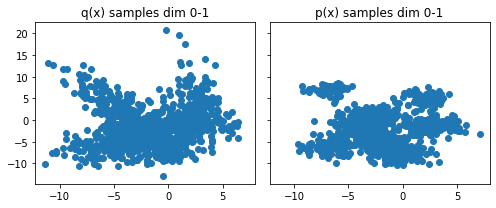

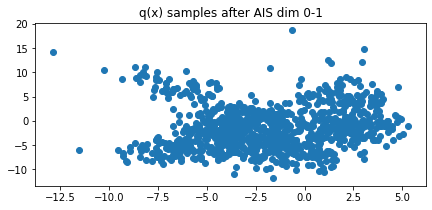

loss: 0.40318909507657935, mean log p_x -5.765163502747692:  30%|██████████████████████████                                                             | 9/30 [01:00<02:08,  6.13s/it]

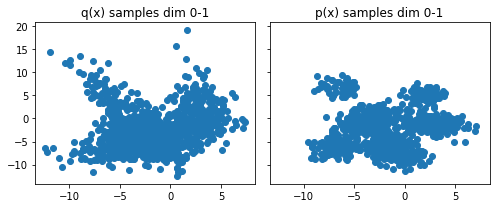

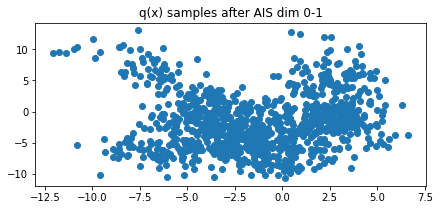

loss: 0.4581502798944633, mean log p_x -5.668510232129996:  40%|██████████████████████████████████▊                                                    | 12/30 [01:18<01:49,  6.07s/it]

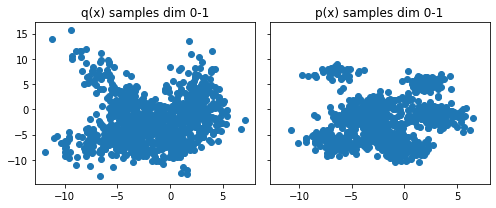

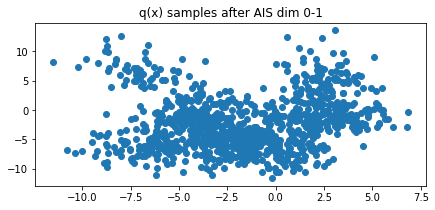

loss: 0.4024339092547894, mean log p_x -5.727312718227315:  50%|███████████████████████████████████████████▌                                           | 15/30 [01:38<01:36,  6.46s/it]

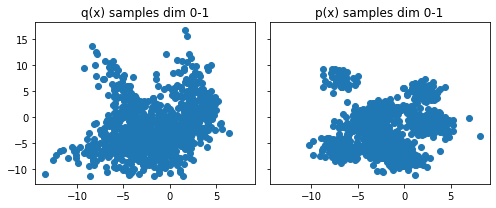

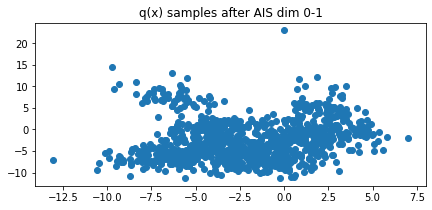

loss: 0.4157680967874732, mean log p_x -5.780615021687523:  60%|████████████████████████████████████████████████████▏                                  | 18/30 [01:57<01:15,  6.26s/it]

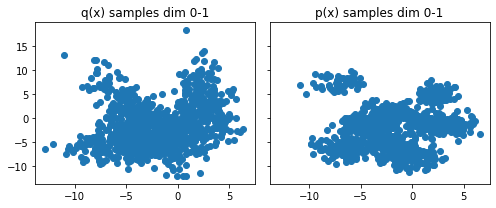

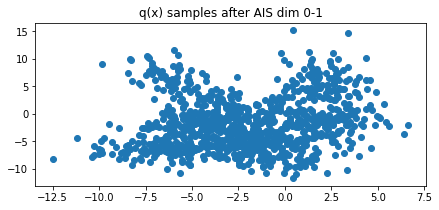

loss: 0.3522697592956741, mean log p_x -5.691096320218137:  70%|████████████████████████████████████████████████████████████▉                          | 21/30 [02:16<00:57,  6.43s/it]

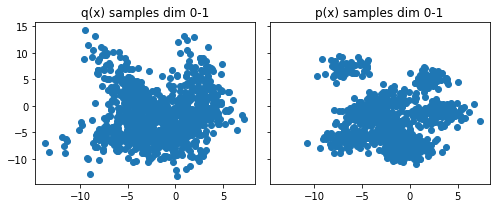

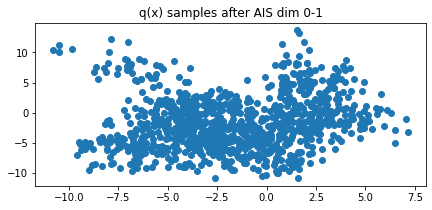

loss: 0.38118549906722166, mean log p_x -5.773356590105471:  80%|████████████████████████████████████████████████████████████████████▊                 | 24/30 [02:33<00:36,  6.07s/it]

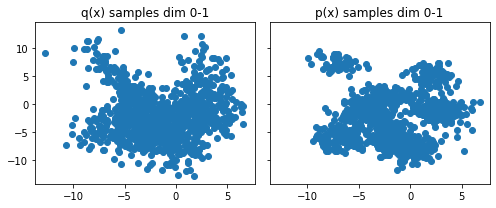

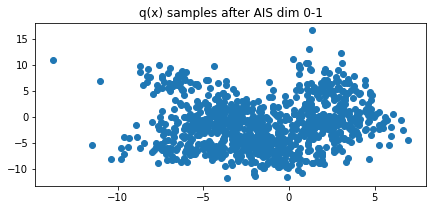

loss: 0.3394979602923903, mean log p_x -5.505545012864059:  90%|██████████████████████████████████████████████████████████████████████████████▎        | 27/30 [02:49<00:16,  5.44s/it]

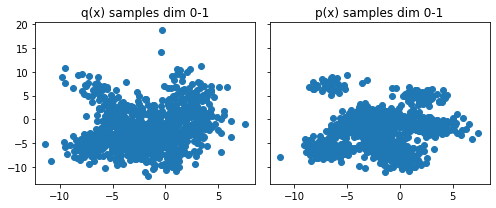

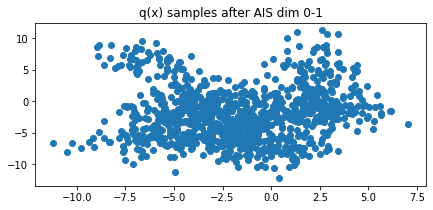

loss: 0.3394979602923903, mean log p_x -5.505545012864059: 100%|███████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:00<00:00,  6.02s/it]


In [67]:
history = tester.train(30, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

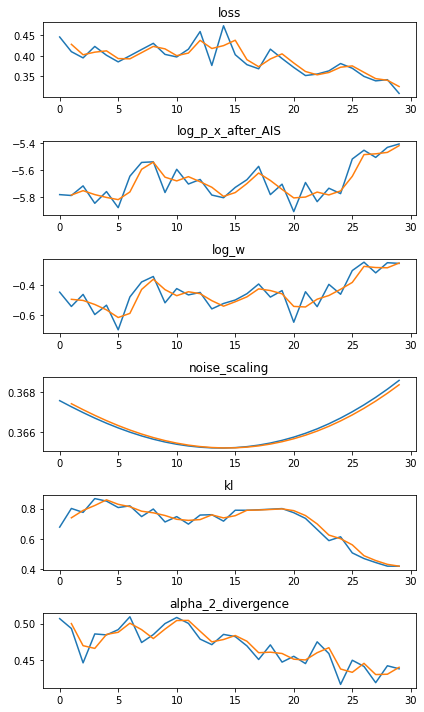

In [68]:
plot_history(history)
plot_samples(tester)
plot_samples(tester, n_samples=100)

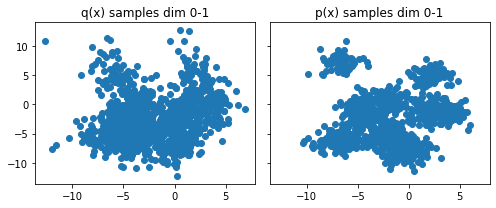

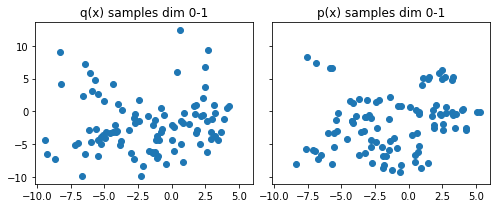

loss: 0.35134910039923756, mean log p_x -5.397274015200303:   0%|                                                                                              | 0/100 [00:04<?, ?it/s]

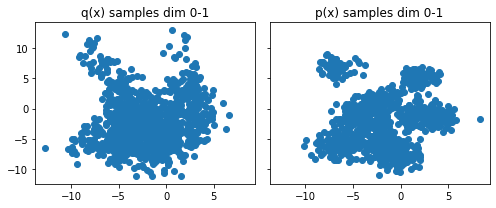

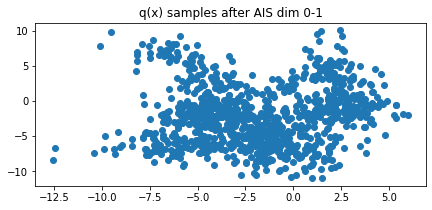

loss: 0.315327301199639, mean log p_x -5.526301338291074:  10%|████████▋                                                                              | 10/100 [00:58<08:01,  5.35s/it]

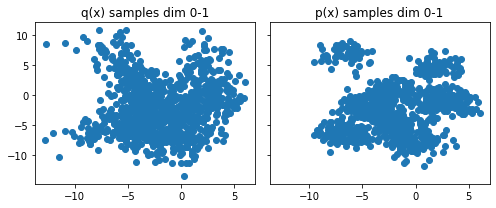

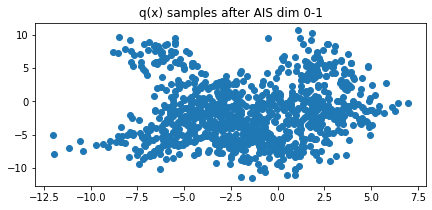

loss: 0.3233288411181769, mean log p_x -5.376159046742273:  20%|█████████████████▏                                                                    | 20/100 [01:48<06:36,  4.95s/it]

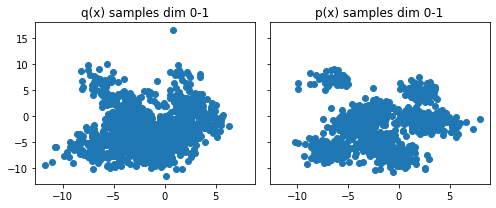

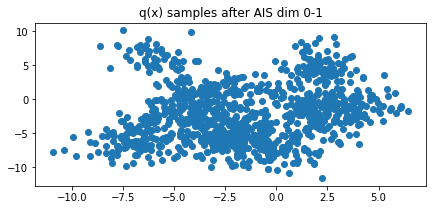

loss: 0.29655605747902064, mean log p_x -5.524993999213667:  30%|█████████████████████████▌                                                           | 30/100 [02:37<05:42,  4.89s/it]

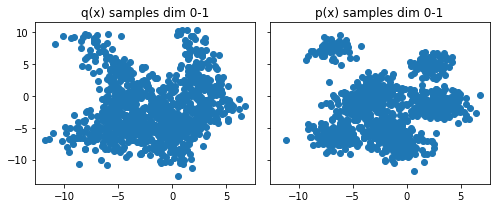

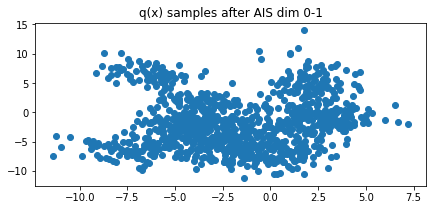

loss: 0.30109877643378075, mean log p_x -5.385463739048777:  40%|██████████████████████████████████                                                   | 40/100 [03:30<04:59,  4.98s/it]

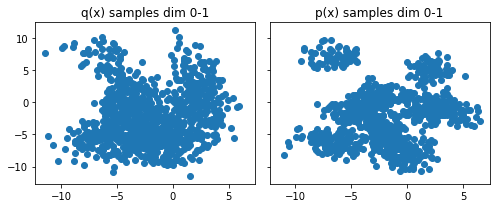

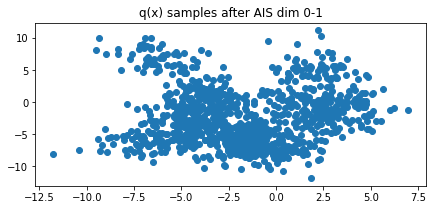

loss: 0.2775738855557295, mean log p_x -5.403683449397778:  50%|███████████████████████████████████████████                                           | 50/100 [04:18<04:04,  4.88s/it]

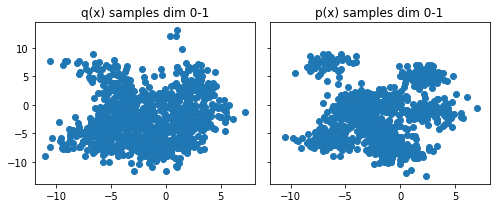

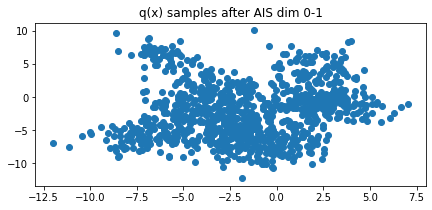

loss: 0.24678432517208168, mean log p_x -5.371295360847964:  60%|███████████████████████████████████████████████████                                  | 60/100 [05:07<03:15,  4.89s/it]

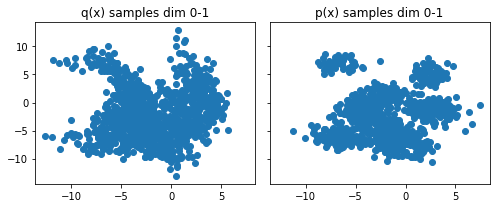

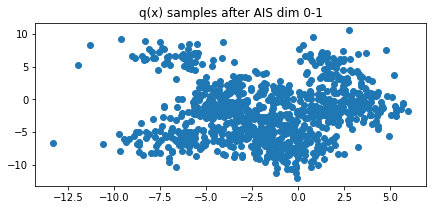

loss: 0.23631744615766742, mean log p_x -5.415215093239297:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [05:56<02:23,  4.80s/it]

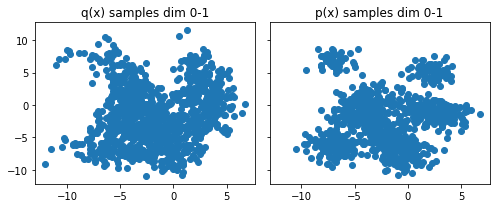

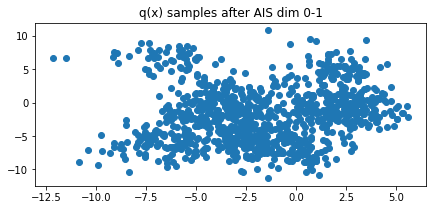

loss: 0.24557415003577476, mean log p_x -5.430944604977539:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [06:46<01:38,  4.92s/it]

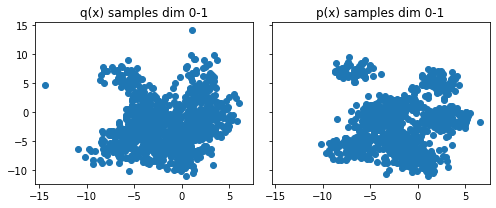

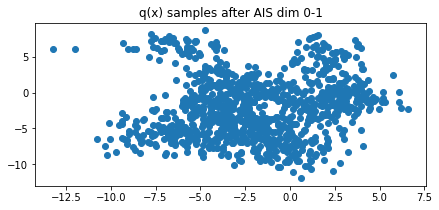

loss: 0.23244703686045068, mean log p_x -5.459123685946159:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [07:41<00:56,  5.67s/it]

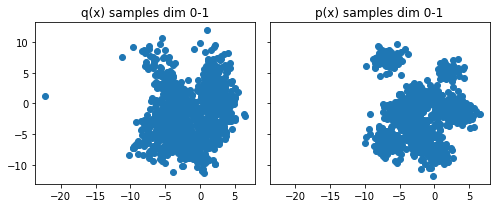

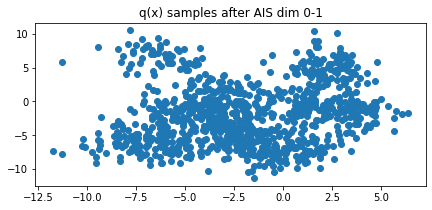

loss: 0.23244703686045068, mean log p_x -5.459123685946159: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:31<00:00,  5.11s/it]


In [71]:
history = tester.train(100, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)

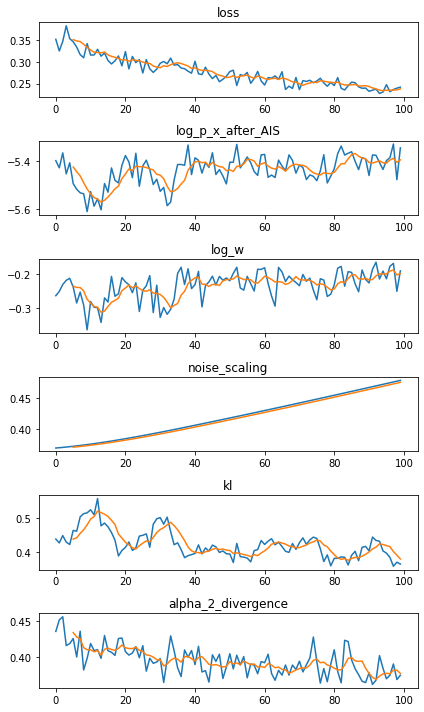

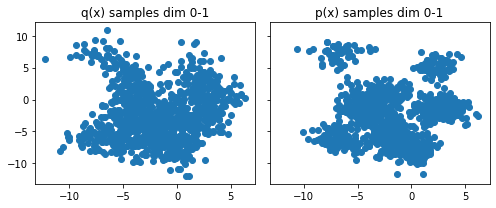

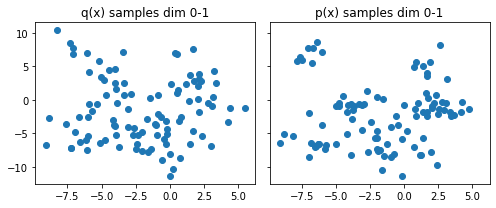

In [72]:
plot_history(history)
plot_samples(tester)

loss: 0.23081137839467986, mean log p_x -5.342685512237309:   0%|                                                                                              | 0/100 [00:04<?, ?it/s]

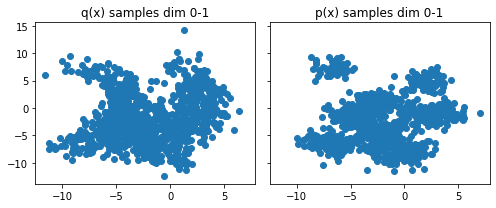

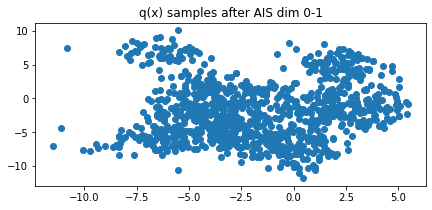

loss: 0.22130248092606866, mean log p_x -5.28554786333789:  50%|███████████████████████████████████████████                                           | 50/100 [04:14<04:14,  5.09s/it]

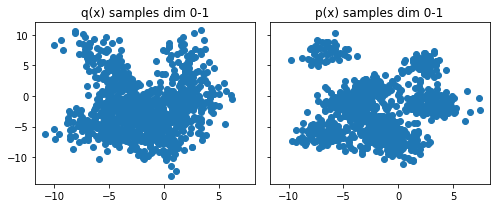

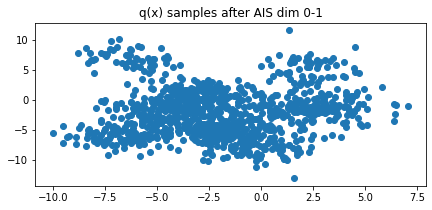

loss: 0.19591746888468195, mean log p_x -5.325897798369559: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:15<00:00,  4.95s/it]
loss: 0.16796496334895014, mean log p_x -5.2940934490881535:   0%|                                                                                             | 0/100 [00:04<?, ?it/s]

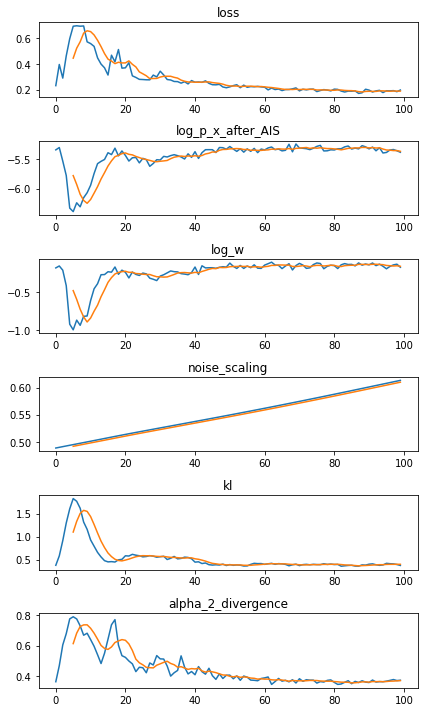

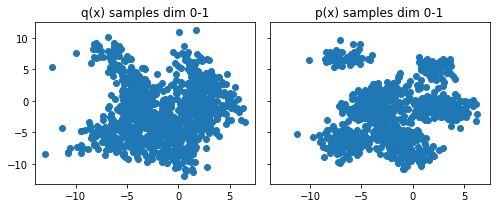

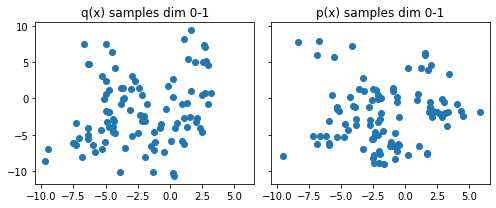

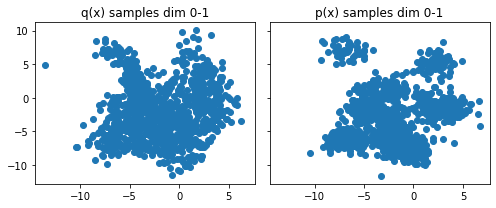

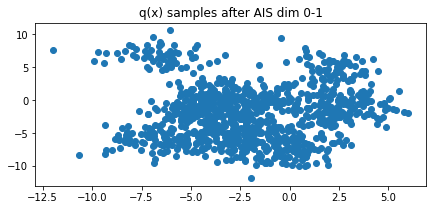

loss: 0.16899110990490188, mean log p_x -5.270537282217284:  50%|██████████████████████████████████████████▌                                          | 50/100 [04:12<04:09,  5.00s/it]

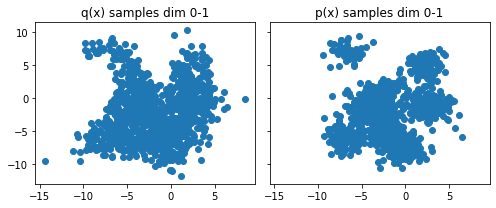

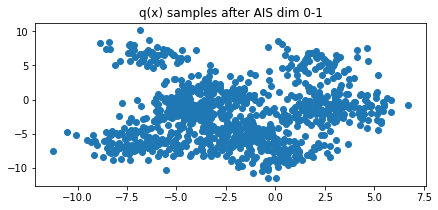

loss: 0.1723846725536611, mean log p_x -5.244225272591726: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:18<00:00,  4.99s/it]
loss: 0.1530632748217219, mean log p_x -5.203452399501081:   0%|                                                                                               | 0/100 [00:04<?, ?it/s]

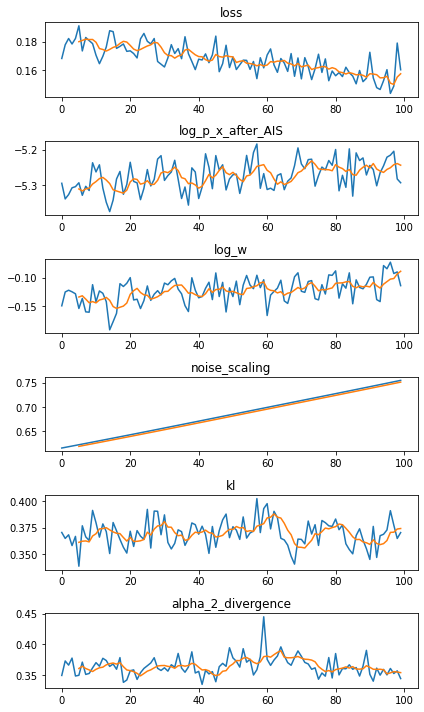

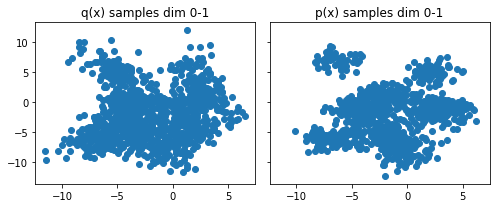

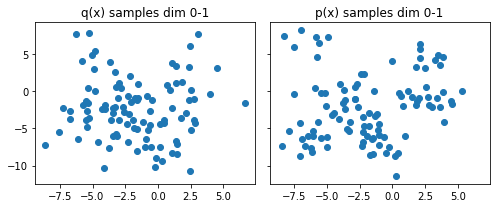

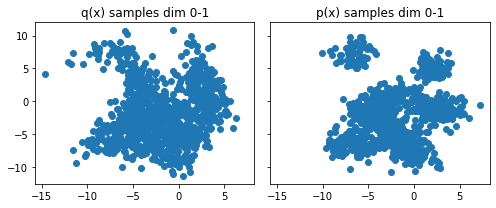

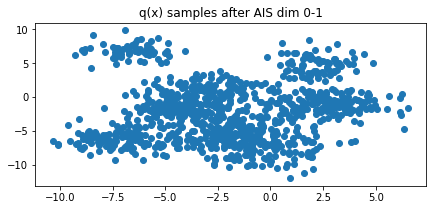

loss: 0.14144078015079228, mean log p_x -5.291289212837006:  50%|██████████████████████████████████████████▌                                          | 50/100 [04:16<04:10,  5.00s/it]

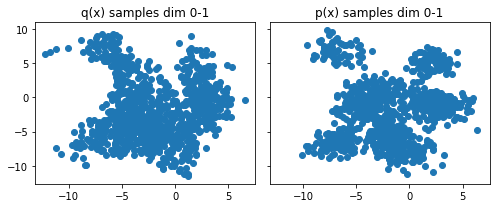

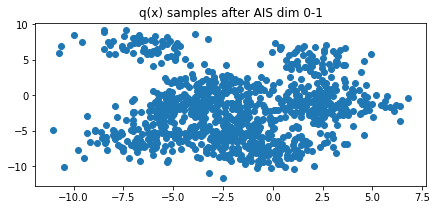

loss: 0.12666600955783766, mean log p_x -5.1893843464761265:  81%|████████████████████████████████████████████████████████████████████                | 81/100 [06:48<01:35,  5.04s/it]
  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

failed on run 2


loss: 0.13073435581789158, mean log p_x -5.267533557150826:   0%|                                                                                              | 0/100 [00:04<?, ?it/s]

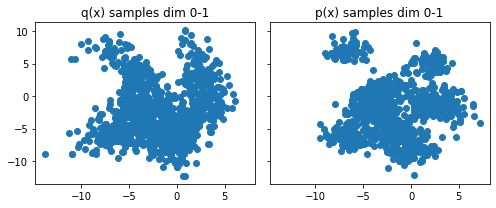

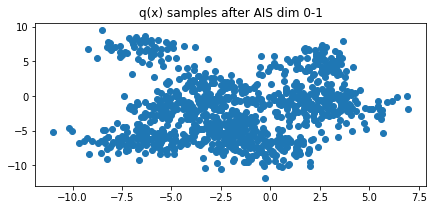

loss: 0.12592795943978505, mean log p_x -5.203066790789193:  39%|█████████████████████████████████▏                                                   | 39/100 [03:14<05:04,  5.00s/it]
  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

failed on run 3


loss: 0.13087271898553002, mean log p_x -5.280171752026005:   0%|                                                                                              | 0/100 [00:04<?, ?it/s]

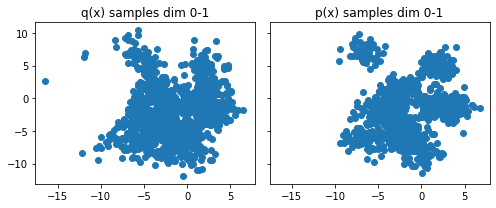

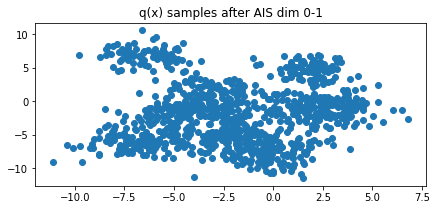

loss: 0.11522944682758417, mean log p_x -5.302478239185728:  50%|██████████████████████████████████████████▌                                          | 50/100 [04:15<04:10,  5.01s/it]

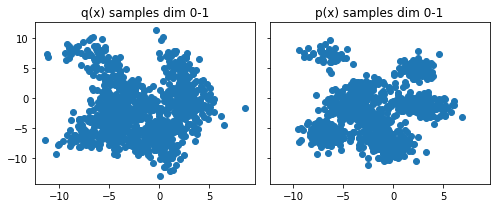

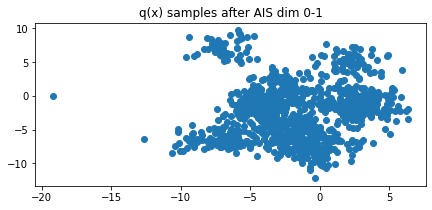

loss: 0.11522944682758417, mean log p_x -5.302478239185728:  54%|█████████████████████████████████████████████▉                                       | 54/100 [04:33<03:52,  5.06s/it]
  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

failed on run 4


loss: 0.10834462284490579, mean log p_x -5.212270903989245:   0%|                                                                                              | 0/100 [00:04<?, ?it/s]

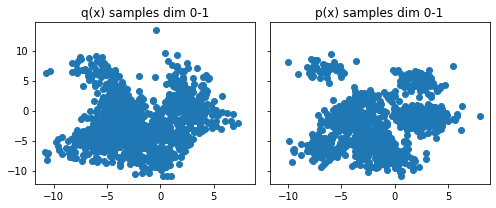

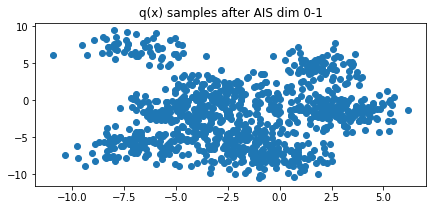

loss: 0.11387179772311153, mean log p_x -5.198118446219786:  24%|████████████████████▍                                                                | 24/100 [02:02<06:29,  5.12s/it]
  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

failed on run 5


loss: 0.10801232092164448, mean log p_x -5.191513657174429:   0%|                                                                                              | 0/100 [00:04<?, ?it/s]

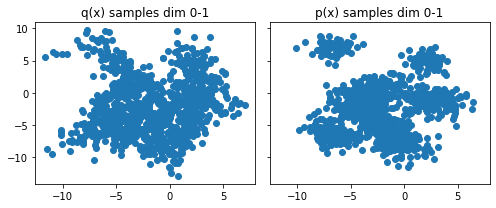

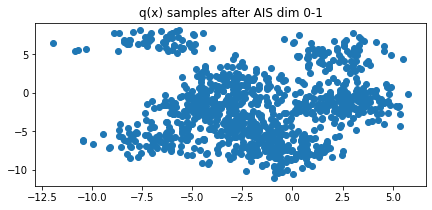

loss: 0.10314469279551151, mean log p_x -5.1929369666034635:  35%|█████████████████████████████▍                                                      | 35/100 [02:58<05:32,  5.11s/it]
  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

failed on run 6


loss: 0.10620791849800372, mean log p_x -5.207650119706976:   0%|                                                                                              | 0/100 [00:04<?, ?it/s]

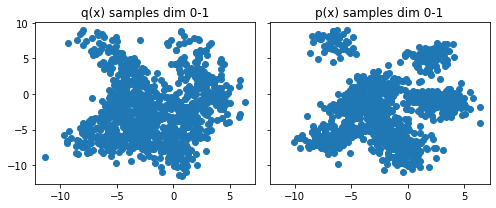

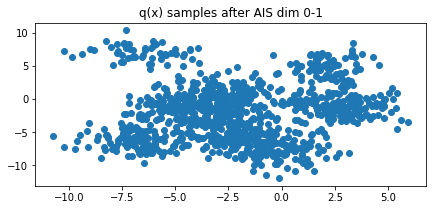

loss: 0.10246178681683091, mean log p_x -5.245159250804357:  34%|████████████████████████████▉                                                        | 34/100 [02:52<05:35,  5.08s/it]
  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

failed on run 7


loss: 0.09870812011686513, mean log p_x -5.1977028101446:   0%|                                                                                                | 0/100 [00:04<?, ?it/s]

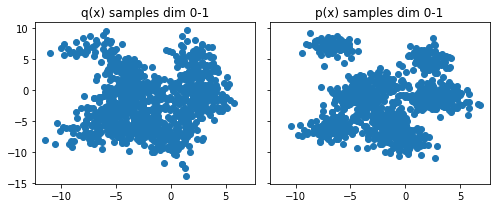

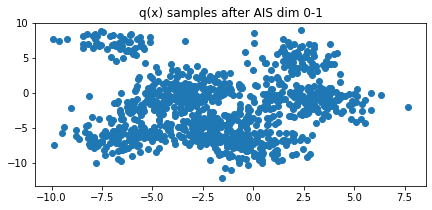

loss: 0.09859382659724417, mean log p_x -5.179146777274138:  29%|████████████████████████▋                                                            | 29/100 [02:25<05:56,  5.01s/it]
  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

failed on run 8


  0%|                                                                                                                                                          | 0/100 [00:03<?, ?it/s]

failed on run 9


In [74]:
for i in range(10):
    try:
        history = tester.train(100, batch_size=1000, intermediate_plots=True, n_plots=2, plotting_func=plotter)
        plot_history(history)
        plot_samples(tester)
    except:
        print(f"failed on run {i}")

# Old

loss: 1.8430109099044314, mean log p_x -8.801438653711811:   0%|                                                                                               | 0/100 [00:06<?, ?it/s]

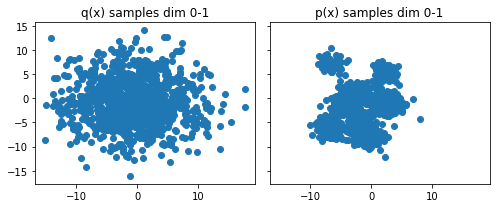

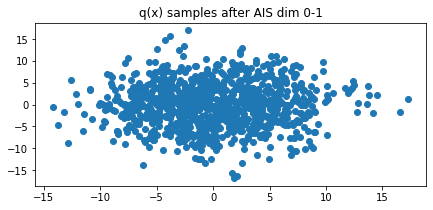

loss: 1.1235319720064196, mean log p_x -7.384940796607003:  10%|████████▌                                                                             | 10/100 [01:16<10:43,  7.15s/it]

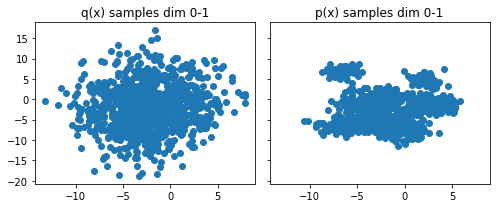

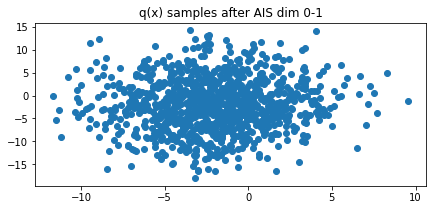

loss: 1.2048313976960046, mean log p_x -7.178976250402814:  20%|█████████████████▏                                                                    | 20/100 [02:27<09:25,  7.07s/it]

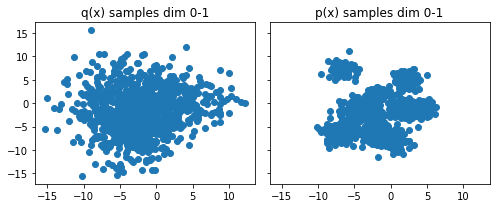

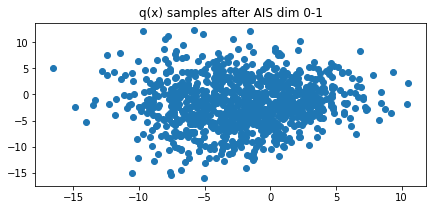

loss: 1.1384263553104204, mean log p_x -7.33133965401957:  30%|██████████████████████████                                                             | 30/100 [03:23<05:52,  5.03s/it]

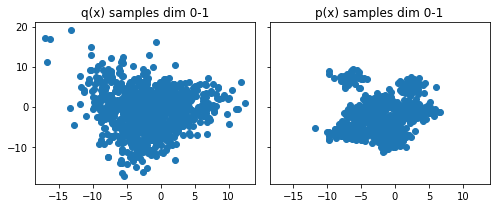

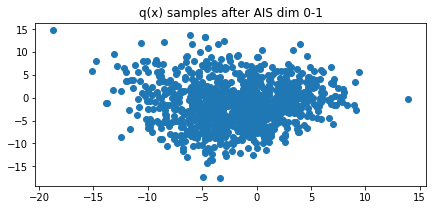

loss: 1.0401379111699718, mean log p_x -6.8004716357602195:  40%|██████████████████████████████████                                                   | 40/100 [04:08<04:38,  4.65s/it]

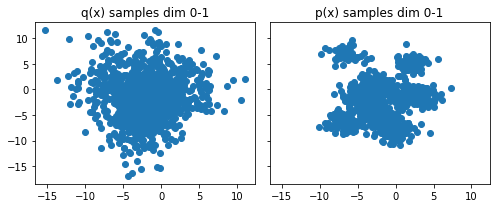

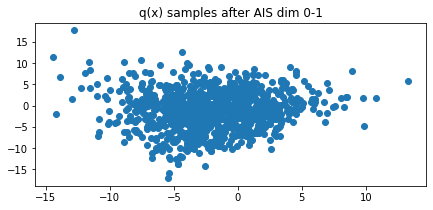

loss: 1.0320445569488024, mean log p_x -7.716947955979752:  50%|███████████████████████████████████████████                                           | 50/100 [04:56<03:45,  4.52s/it]

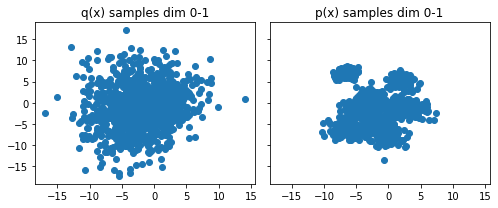

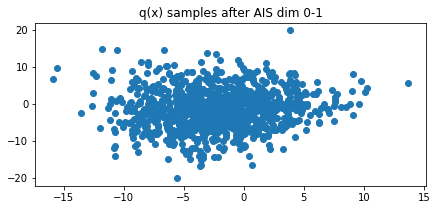

loss: 1.0298104445304646, mean log p_x -6.624704061347373:  60%|███████████████████████████████████████████████████▌                                  | 60/100 [05:43<03:06,  4.67s/it]

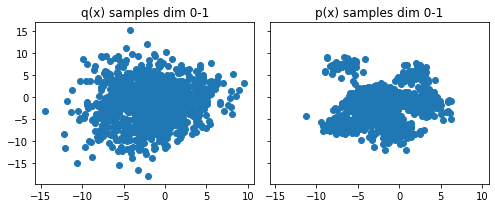

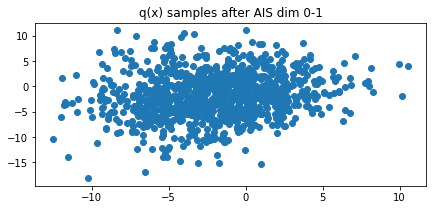

loss: 1.1427519714558763, mean log p_x -6.733718689714944:  70%|████████████████████████████████████████████████████████████▏                         | 70/100 [06:30<02:17,  4.58s/it]

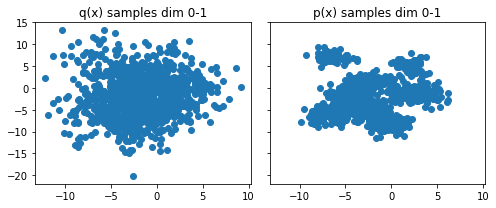

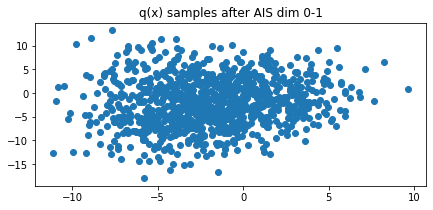

loss: 1.03199686796658, mean log p_x -6.628321424578498:  80%|██████████████████████████████████████████████████████████████████████▍                 | 80/100 [07:16<01:31,  4.59s/it]

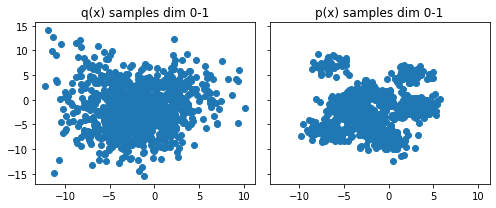

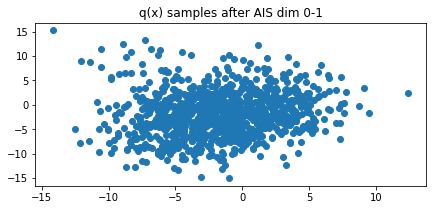

loss: 1.0317031141426256, mean log p_x -6.535843764311363:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 90/100 [08:11<00:53,  5.37s/it]

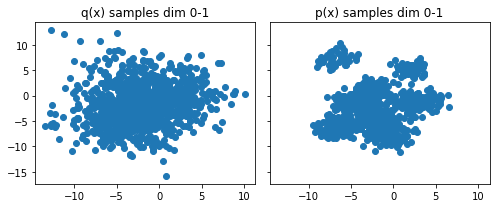

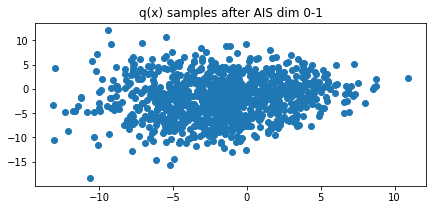

loss: 1.0317031141426256, mean log p_x -6.535843764311363: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:08<00:00,  5.49s/it]


In [39]:
history = tester.train(100, batch_size=1000, intermediate_plots=True, n_plots=10, plotting_func=plotter)